In [88]:
import os; import subprocess

def detect_env():
    return 'colab' if 'content' in os.listdir('/') else 'IBM'
  
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
if detect_env() == 'colab': root_folder = '/content'
elif detect_env() == 'IBM' : root_folder = '/root/Derakhshani/adversarial'
python_files_path = root_folder + '/nag-public'

if os.path.isdir(python_files_path):
  initial_dir = os.getcwd()
  os.chdir(python_files_path)
  run_shell_command('git pull')
  os.chdir(initial_dir)
else:
  os.chdir('/root/Derakhshani/adversarial')
  run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')

Already up-to-date.



In [89]:
import sys
sys.path.append(python_files_path + '/NAG-11May-beforeDenoiser')

from nag_util import *
import nag_util
from environment import *
from visualization import *

env = create_env()
env.setup(cuda_index = 0)

In [90]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import numpy as np
import sys; import os; import shutil

In [91]:
gen_arch = "targeted"
# gen_arch = "non-targeted"

In [92]:
class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [93]:
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        self.activation = activation

        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return F.relu(self.BN2d(self.CT2d(input)), inplace=True)
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)

In [94]:
if gen_arch == "targeted":
  class Gen(nn.Module):
    def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
      super(Gen, self).__init__()

      self.bs = None
      self.z_dim = z_dim
      self.gf_dim = gf_dim
      self.y_dim = y_dim
      self.df_dim = df_dim
      self.image_shape = image_shape
      self.n_active_labels = 10
      
#       self.n_units_coeffs = [7, 4, 2, 1, 1, 1, 1]
      self.n_unit_coeffs = [10, 7, 4, 2, 1, 1, 1]
      self.n_units = [coeff * self.gf_dim for coeff in self.n_unit_coeffs]
      
      self.z_ = nn.Linear(self.z_dim, self.n_units[0] * 4 * 4, bias=True)
      self.z_.bias.data.fill_(0)
      self.BN_ = nn.BatchNorm2d(self.n_units[0])

      self.half = max(self.gf_dim // 2, 1) 
      self.quarter = max(self.gf_dim // 4, 1)
      self.eighth = max(self.gf_dim // 8, 1)
      # sixteenth = max(self.gf_dim // 16, 1)

      self.CT2d_1 = deconv_layer(self.n_units[0], self.n_units[1], k_size = (5,5), pad = (2,2))
      self.CT2d_2 = deconv_layer(self.n_units[1], self.n_units[2])    
      self.CT2d_3 = deconv_layer(self.n_units[2], self.n_units[3])
      self.CT2d_4 = deconv_layer(self.n_units[3], self.n_units[4])
      self.CT2d_5 = deconv_layer(self.n_units[4], self.n_units[5])
      self.CT2d_6 = deconv_layer(self.n_units[5], self.n_units[6])
      self.CT2d_7 = deconv_layer(self.n_units[6], 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

    def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
      h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
      h_input = torch.cat([h_input, h_input_z], dim = 1)
      output = deconv_layer(h_input)
      assert output.shape[2:] == (expected_output_size, expected_output_size), \
              "Unexpected output shape at randomized_deconv_layer. expected" + \
              "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
      return output

    def forward_z(self, z):
      self.bs = z.shape[0]

      h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
      assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

      h1 = self.CT2d_1(h0)
      h2 = self.CT2d_2(h1)
      h3 = self.CT2d_3(h2)
      h4 = self.CT2d_4(h3)
      h5 = self.CT2d_5(h4)
      h6 = self.CT2d_6(h5)
      h7 = self.CT2d_7(h6)
      
      
#       h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#       h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#       h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#       h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#       h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#       h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#       h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

      ksi = 10.0
      output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
      # this coeff scales the output to be appropriate for images that are 
      # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
      # interval)
      return output_coeff * torch.tanh(h7)

  #   # blind-selection
    def forward(self, inputs):
      self.bs = inputs.shape[0]

      benign_preds_onehot = arch(inputs)
      benign_preds = torch.argmax(benign_preds_onehot, dim = 1)

      z = torch.zeros([self.bs, 1000]).cuda()
      for i in range(self.bs):
        random_label = self.randint(0, self.n_active_labels, exclude = benign_preds[i].item())
        z[i][random_label] = 1.

      z_out = self.forward_z(z)

      return z_out, None, None, inputs, benign_preds_onehot, z

  #   #second-best selection: made validation so much worse
  #   def forward(self, inputs):
  #     self.bs = inputs.shape[0]

  #     benign_preds_onehot = arch(inputs)
  #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]

  #     z = torch.zeros([self.bs, 1000]).cuda()
  #     for i in range(self.bs):
  #       z[i][target_preds[i]] = 1.

  #     z_out = self.forward_z(z)

  #     return z_out, None, None, inputs, benign_preds_onehot, z

  #    def forward(self, inputs):
  #     self.bs = inputs.shape[0]

  #     benign_preds_onehot = arch(inputs)
  #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)

  #     z = torch.zeros([self.bs, 1000]).cuda()
  #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
  #     for i in range(self.bs):
  #       z[i][random_label] = 1.

  #     z_out = self.forward_z(z)

  #     return z_out, None, None, inputs, benign_preds_onehot, z

    @staticmethod
    def randint(low, high, exclude):
      if exclude >= low and exclude < high:
        temp = np.random.randint(low, high - 1)
        if temp >= exclude:
          temp = temp + 1
        return temp
      else:
        return np.random.randint(low, high)

    def forward_single_z(self, z):
      return self.forward_z(z[None]).squeeze()

    def generate_single_noise(self):
      z = torch.empty(self.z_dim).uniform_(-1,1).cuda()
      return self.forward_single_z(z)         

    def make_triplet_samples(self, z, margin, r2, r3):
      positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
      negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
      return positive_sample, negative_sample

    def random_vector_surface(self, shape, r = 1.):
      mat = torch.randn(size=shape).cuda()
      norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
      return (mat/norm) * r


    def random_vector_volume(self, shape, inner_r, outer_r):
      fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
      fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
      fraction.unsqueeze_(-1)
      return self.random_vector_surface(shape, 1) * fraction

    def make_z(self, in_shape):
      return torch.empty(in_shape).cuda().uniform_(-1,1)


In [95]:
# g = Gen(z_dim = 1000).cuda()
# t = torch.empty(1000).uniform_().cuda()
# g.forward_single_z(t).shape

In [96]:
if gen_arch == "non-targeted":
  class Gen(nn.Module):
    def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
      super(Gen, self).__init__()

      self.bs = None
      self.z_dim = z_dim
      self.gf_dim = gf_dim
      self.y_dim = y_dim
      self.df_dim = df_dim
      self.image_shape = image_shape

      self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
      self.z_.bias.data.fill_(0)
      self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

      self.half = max(self.gf_dim // 2, 1) 
      self.quarter = max(self.gf_dim // 4, 1)
      self.eighth = max(self.gf_dim // 8, 1)
      # sixteenth = max(self.gf_dim // 16, 1)

      self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
      self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
      self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
      self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
      self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
      self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
      self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

    def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
      h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
      h_input = torch.cat([h_input, h_input_z], dim = 1)
      output = deconv_layer(h_input)
      assert output.shape[2:] == (expected_output_size, expected_output_size), \
              "Unexpected output shape at randomized_deconv_layer. expected" + \
              "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
      return output

    def forward_z(self, z):
      self.bs = z.shape[0]

      h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
      assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

      h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
      h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
      h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
      h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
      h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
      h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
      h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

      ksi = 10.0
      output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
      # this coeff scales the output to be appropriate for images that are 
      # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
      # interval)
      return output_coeff * torch.tanh(h7)

    def forward(self, inputs):
      self.bs = inputs.shape[0]
      z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
      p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)

      z_out = self.forward_z(z)
#       p_out = self.forward_z(p)
#       n_out = self.forward_z(n)

#       return z_out, p_out, n_out, inputs, z
      return z_out, None, None, inputs, z

    def forward_single_z(self, z):
      return self.forward_z(z[None]).squeeze()

    def generate_single_noise(self):
      z = torch.empty(self.z_dim).uniform_(-1,1).cuda()
      return self.forward_single_z(z)


    def make_triplet_samples(self, z, margin, r2, r3):
      positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
      negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
      return positive_sample, negative_sample

    def random_vector_surface(self, shape, r = 1.):
      mat = torch.randn(size=shape).cuda()
      norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
      return (mat/norm) * r


    def random_vector_volume(self, shape, inner_r, outer_r):
      fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
      fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
      fraction.unsqueeze_(-1)
      return self.random_vector_surface(shape, 1) * fraction

    def make_z(self, in_shape):
      return torch.empty(in_shape).cuda().uniform_(-1,1)

In [97]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))


def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  triplet_loss.call_count += 1
  if triplet_loss.call_count % 200 == 0 : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

triplet_loss.call_count = 0

In [98]:
# def diversity_loss(embeddings, z_s):
#   size = z_s.shape[0]
#   result = 0
#   for i in range(size):
#     for j in range(i+1, size):
# #       a = F.cosine_similarity(embeddings[i], embeddings[j], dim = 0)
# #       b = torch.norm(z_s[i] - z_s[j], 2, dim = 0)
# #       print('embeddings: ')
# #       print_big_vector(embeddings[i])
# #       print_big_vector(embeddings[j])
# #       print(f'a: {a}, b:{b}, multiple: {a*b}')
#       result += F.cosine_similarity(embeddings[i], embeddings[j], dim = 0) * \
#                 torch.norm(z_s[i] - z_s[j], 2, dim = 0)
#   n_pairs = (size * (size - 1)) / 2
#   mean = result / n_pairs 
# #   print(f'result {result}, n_pairs {n_pairs}, mean {mean}')
#   return mean
  

# # normalized with shuffling
# def diversity_loss(embeddings, deranged_embeddings, z_s, deranged_z_s):
#     cos_similarity = F.cosine_similarity(embeddings, deranged_embeddings)
#     z_distance = torch.norm(z_s - deranged_z_s, 2, dim = 1)
#     return torch.mean(cos_similarity * z_distance)
  
# # normalized with shuffling
# def diversity_loss(embeddings, z_s):
#     deranged_embeddings, deranged_z_s = derange(embeddings, z_s)
#     cos_similarity = F.cosine_similarity(embeddings, deranged_embeddings)
#     z_distance = torch.norm(z_s - deranged_z_s, dim = 1)
#     max_possible_z_distance = 6.3246
#     return torch.mean(cos_similarity * (z_distance/max_possible_z_distance))


def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))


if gen_arch == 'non-targeted':
  def fool_loss(input, target):
    true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
    target_probabilities = input.gather(1, true_class)
    epsilon = 1e-10
    result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))

    fool_loss.call_count += 1
    if fool_loss.call_count % 200 == 0:
      print("target probs {}, loss: {}: ".format(target_probabilities, result))

    return result

  fool_loss.call_count = 0

if gen_arch == 'targeted':
  def fool_loss(model_output, target_labels):
    target_labels = target_labels.view(-1, 1).long().cuda()
    target_probabilities = model_output.gather(1, target_labels)
    epsilon = 1e-10
    # highest possible fool_loss is - log(1e-10) == 23
    result = torch.mean(-1 * torch.log(target_probabilities + epsilon))

    fool_loss.call_count += 1
    if fool_loss.call_count % 200 == 0:
      print("target probs {}, loss: {}: ".format(target_probabilities, result))

    return result

  fool_loss.call_count = 0


def targeted_validation(gen_output, target):
  perturbations, _, _, clean_images, _, z = gen_output
  perturbed_images = clean_images + perturbations
  target_labels = torch.argmax(z, 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
#   print('adv preds: ', adversary_preds.shape, adversary_preds)
#   print('target_labels: ', target_labels.shape, target_labels)
#   print('eq: ', (adversary_preds == target_labels))
  return (adversary_preds == target_labels).float().mean()
  

# # targeted 
# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   return validation_(perturbations, clean_images)

# # non-targeted
# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _ = gen_output
#   return validation_(perturbations, clean_images)

# # general
def validation(gen_output, target):
  perturbations = gen_output[0]
  clean_images = gen_output[3]
  return validation_(perturbations, clean_images)

unfooled_histogram = np.array([0.] * 1000)
fooled_histogram = np.array([0.] * 1000)
valid_cnt = 0

def print_hist(unfooled, fooled):
  indexed = [(i, u) for i, u in enumerate(unfooled)]
  summarized = list(filter(lambda x: x[1] > 0.0, indexed))
  total = fooled + unfooled

  percent_total = [(i, 100. * u / (total[i] + 1e-10), total[i]) for i, u in enumerate(unfooled)]
  sorted_percent_total = sorted(percent_total, key =lambda x: x[1], reverse = True)

  print('\npercent_total: ')
  print(list(filter(lambda x: x[1] > 0.0, sorted_percent_total)))
  print('\n')
  
  return sorted_percent_total

def validation_(perturbations, clean_images):
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)

  is_unfooled = (benign_preds == adversary_preds)
  for i , unfooled in enumerate(is_unfooled):
    if unfooled == 1:
      unfooled_histogram[benign_preds[i]] += 1
    else:
      fooled_histogram[benign_preds[i]] += 1
  
  global valid_cnt
  valid_cnt += 1
  if valid_cnt % 10 == 0:
    print_hist(unfooled_histogram, fooled_histogram)
    
  return (benign_preds != adversary_preds).float().mean()

In [99]:
if gen_arch == 'targeted':
  class FeatureLoss(nn.Module):
      def __name__(self):
        return "feature_loss"

      def __init__(self, dis, layers, layer_weights):
          super().__init__()

          # define generator here 
          self.dis = dis
          self.diversity_layers = layers
          self.hooks = hook_outputs(self.diversity_layers, detach=False)
          self.weights = layer_weights
          self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
  #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)

      def make_features(self, x, clone=False):
          y = self.dis(x)
          return y, [(o.clone() if clone else o) for o in self.hooks.stored]

      def forward(self, inp, target):
        sigma_B, _, _, X_B, B_Y, z = inp

        X_A = X_B + sigma_B
  #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

        A_Y, A_feat = self.make_features(X_A)
  #       _, S_feat = self.make_features(X_S)

        chosen_labels = z.argmax(dim=1)
        fooling_loss =  fool_loss(A_Y, chosen_labels)

  #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
  #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

  #       self.losses = [fooling_loss] + weighted_diversity_losses
  #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

        self.losses = [fooling_loss]
        self.metrics = dict(zip(self.metric_names, [fooling_loss]))

        return sum(self.losses)

      def add_perturbation_shuffled(self, inp, perturbation):
  #       j = torch.randperm(inp.shape[0])
          j = derangement(inp.shape[0])
          return inp.add(perturbation[j])

In [100]:
def derange(*args):
  if len(args) == 0: raise ValueError('shuffle function needs atleast one argument')
  deranged_indexes = derangement(args[0].shape[0])
  if not all([args[0].shape[0] == arg.shape[0] for arg in args]): 
    raise ValueError('inputs to shuffle must all have the same 0th dimension')
  return [arg[deranged_indexes] for arg in args]

In [101]:
if gen_arch == 'non-targeted':
  class FeatureLoss(nn.Module):
      def __name__(self):
        return "feature_loss"

      def __init__(self, dis, layers, layer_weights):
          super().__init__()

          self.dis = dis
          self.diversity_layers = layers
          self.hooks = hook_outputs(self.diversity_layers, detach=False)
          self.weights = layer_weights

  #         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
  #         self.metric_names = ["div_loss"] + ['triplet_loss']# Maybe Gram
          self.metric_names = ["fool_loss"] + ['div_loss']# Maybe Gram
          self.triplet_weight = 4.
          self.div_weight = 1.
          self.fooling_weight = 1.

      def make_features(self, x, clone=False):
          y = self.dis(x)
          return y, [(o.clone() if clone else o) for o in self.hooks.stored]

      # contrastive loss
      def forward(self, inp, target):
          sigma_B, sigma_pos, sigma_neg, X_B, z_B = inp

          deranged_perturbations, deranged_z_s = derange(sigma_B, z_B)

          X_A = X_B + sigma_B
          X_S = X_B + deranged_perturbations
#           X_A_pos = X_B + sigma_pos
#           X_A_neg = X_B + sigma_neg

          B_Y, _ = self.make_features(X_B)
          A_Y, A_feat = self.make_features(X_A)
          _, S_feat = self.make_features(X_S)
#           pos_softmax, _ = self.make_features(X_A_pos)
#           neg_softmax, _ = self.make_features(X_A_neg)

          raw_fooling_loss =  fool_loss(A_Y, B_Y)
          weighted_fooling_loss = self.fooling_weight * raw_fooling_loss

#           raw_diversity_loss = diversity_loss(A_feat[0], S_feat[0], z_B, deranged_z_s)
          raw_diversity_loss = diversity_loss(A_feat[0], S_feat[0])
          weighted_diversity_loss = raw_diversity_loss * self.div_weight

#           raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#           weighted_triplet_loss = raw_triplet_loss * self.triplet_weight

  #         self.losses = weighted_diversity_losses + [weighted_triplet_loss]
  #         raw_losses = raw_diversity_losses + [raw_triplet_loss]

          self.losses = [weighted_fooling_loss] + [weighted_diversity_loss] #+ [weighted_triplet_loss]
          raw_losses = [raw_fooling_loss] + [raw_diversity_loss] #+ [raw_triplet_loss]

  #         self.losses = [fooling_loss] + [weighted_triplet_loss]
  #         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

          if len(self.metric_names) != len(raw_losses):
            raise Exception("length of metric names unequals length of losses")

          self.metrics = dict(zip(self.metric_names, raw_losses))
          return sum(self.losses)



  # #     triplet loss
  #     def forward(self, inp, target):
  #         sigma_B, sigma_pos, sigma_neg, X_B, _ = inp

  #         X_A = self.add_perturbation(X_B, sigma_B) 
  #         X_A_pos = self.add_perturbation(X_B, sigma_pos)
  #         X_A_neg = self.add_perturbation(X_B, sigma_neg) 
  #         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

  # #         B_Y, _ = self.make_features(X_B)
  #         A_Y, A_feat = self.make_features(X_A)
  # #         _, S_feat = self.make_features(X_S)
  #         pos_softmax, _ = self.make_features(X_A_pos)
  #         neg_softmax, _ = self.make_features(X_A_neg)

  # #         raw_fooling_loss =  fool_loss(A_Y, B_Y)
  # #         weighted_fooling_loss = self.fooling_weight * raw_fooling_loss

  #         raw_diversity_losses = [diversity_loss(a_f, s_f, sigma_B, ) for a_f, s_f in zip(A_feat, S_feat)]
  #         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
  #         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
  #         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight

  #         self.losses = weighted_diversity_losses + [weighted_triplet_loss]
  #         raw_losses = raw_diversity_losses + [raw_triplet_loss]

  # #         self.losses = [weighted_fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
  # #         raw_losses = [raw_fooling_loss] + raw_diversity_losses + [raw_triplet_loss]

  # #         self.losses = [fooling_loss] + [weighted_triplet_loss]
  # #         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

  #         if len(self.metric_names) != len(raw_losses):
  #           raise Exception("length of metric names unequals length of losses")

  #         self.metrics = dict(zip(self.metric_names, raw_losses))
  #         return sum(self.losses)


  #     #use two types of triplet losses
  #     def forward(self, inp, target):
  #       sigma_B, sigma_pos, sigma_neg, X_B = inp

  #       X_A = self.add_perturbation(X_B, sigma_B) 
  #       X_A_pos = self.add_perturbation(X_B, sigma_pos)
  #       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

  #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

  #       B_Y, _ = self.make_features(X_B)
  #       A_Y, A_feat = self.make_features(X_A)
  #       _, S_feat = self.make_features(X_S)
  #       pos_softmax, _ = self.make_features(X_A_pos)
  #       neg_softmax, _ = self.make_features(X_A_neg)

  #       fooling_loss =  fool_loss(A_Y, B_Y)

  #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
  #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

  #       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
  #       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm

  #       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
  #       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

  #       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
  #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

  #       return sum(self.losses)

  #     # just fooling and diversity
  #     def forward(self, inp, target):
  #       sigma_B, sigma_pos, sigma_neg, X_B = inp

  #       X_A = self.add_perturbation(X_B, sigma_B) 

  #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

  #       B_Y, _ = self.make_features(X_B)
  #       A_Y, A_feat = self.make_features(X_A)
  #       _, S_feat = self.make_features(X_S)

  #       fooling_loss =  fool_loss(A_Y, B_Y)

  #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
  #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

  #       self.losses = [fooling_loss] + weighted_diversity_losses
  #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

  #       return sum(self.losses)


      def add_perturbation_shuffled(self, inp, perturbation):
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [102]:
import pandas as pd

def produce_summary(root_folder, n_files):
  def writeline(file, values, fmt_string):
    file.write(', '.join(fmt_string.format(v) for v in values) + '\n')
  
  last_rows = []
  for i in range(n_files):
    prefix = '/root/Derakhshani/adversarial/textual_notes/CSVs'
    df = pd.read_csv("{}/{}/{}.csv".format(prefix, root_folder, i))
    last_rows.append(df.iloc[-1][1:-1].values.tolist())
  
  last_rows = np.array(last_rows)
  
  labels = list(df.columns[1:-1])
  means = np.mean(last_rows, axis=0).tolist()
  outfile = open('{}/{}/summary.txt'.format(prefix, root_folder), 'w+')
  outfile.write('means: \n')
  writeline(outfile, labels, '{: >20}')
  writeline(outfile, means, '{: >20.3}')
  outfile.write('\n')
      
  operations = []
  for column in df.columns[1:-1]:
    if column in ['train_loss', 'valid_loss', 'fool_loss', 'triplet_loss'] or column[:8] == 'div_loss':
      operations.append('min')
    elif column in ['validation', 'targeted_validation', 'div_metric', 'entropy']:
      operations.append('max')
    else:
      raise ValueError('column {} is not recognized'.format(column))
    
  results = []
  indexes = []
  
  for i in range(len(operations)):
    values = last_rows[:, i]
    if operations[i] == 'max': operation = np.max
    elif operations[i] == 'min': operation = np.min
    result = operation(values)
    results.append(result)
    indexes.append(values.tolist().index(result))
  
  outfile.write('bests: \n')
  writeline(outfile, labels, '{: >20}')
  writeline(outfile, operations, '{: >20}')
  writeline(outfile, results, '{: >20.3}')
  writeline(outfile, indexes, '{: >20}')

In [103]:
from distutils import dir_util 

def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
  os.mkdir(env.get_csv_dir() + results_dir)
  os.mkdir(env.get_models_dir() + results_dir)
  
  for setting_ind in range(n_settings):
    print(f"investigation no: {setting_ind}")
    learn = None; gen = None; gc.collect()
    gen = Gen(z_dim = z_dim)
    init_cnn(gen, True)
    
    tmp_csv_filename =  env.temp_csv_path + '/' + results_dir + '/' + str(setting_ind)
    csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)

    if gen_arch == 'non-targeted':
      metrics = [validation]
    elif gen_arch == 'targeted':
      metrics = [validation, targeted_validation]
      
    learn = Learner(data, gen, loss_func = feat_loss, metrics=metrics, 
                    model_dir = env.get_learner_models_dir(), 
                    callback_fns=[DiversityMetric, LossMetrics, csv_logger])
    
    saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
    saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

    learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
    shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
    
    model_dest = env.get_models_dir() + results_dir + '/' + str(setting_ind)
    os.mkdir(model_dest)
    dir_util.copy_tree(env.data_path/env.get_learner_models_dir(), model_dest)
    shutil.rmtree(env.data_path/env.get_learner_models_dir())  
    
  produce_summary(results_dir, n_settings)

In [104]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  gen = learn.model.eval()
  perturbations = [gen.generate_single_noise() for _ in range(n_perturbations)]
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations, verbose=False):
  pred_hist = torch.tensor([0] * 1000).detach_()
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 5 == 0 and verbose: print(f"at batch no {batch_no}")
    for j, perturbation in enumerate(perturbations):
      perturbed_batch = batch + perturbation[None]
      preds = arch(perturbed_batch).argmax(1)
      for pred in preds:
        pred_hist[pred] += 1
  pred_hist = pred_hist.float() / len(perturbations)
  return pred_hist.tolist()


def classes_needed_to_reach(percentage, hist):
  hist_sum = np.sum(hist)
  indexed_hist = [(i, hist_element) for i,hist_element in  
                          enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse = True)
  
  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = sorted_hist[n_used_classes]
    cumulative_percent += (hist_elem[1] / hist_sum) * 100.
    n_used_classes += 1

  return n_used_classes, sorted_hist

def diversity(learn, n_perturbations, percentage = 95, verbose = True):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations), verbose
  )
  print("finished creating the prediction histogram")

  return classes_needed_to_reach(95, pred_histogram)

In [105]:
class DiversityMetric(LearnerCallback):
  _order = -20 # Needs to run before the recorder
  
  def __init__(self, learn):
    super().__init__(learn)
    self.average_over = 4
    self.n_perturbations = 10
    self.percentage = 95
  
  def on_train_begin(self, **kwargs):
    self.learn.recorder.add_metric_names(['div_metric', 'entropy'])
    
  def on_epoch_begin(self, **kwargs):
    global learn
    self.perturbations_list = [generate_perturbations(self.learn, self.n_perturbations) \
                          for _ in range(self.average_over)]
    self.pred_hist_list = [torch.tensor([0] * 1000).detach_() for _ in range(self.average_over)]
    
  def on_batch_end(self, last_output, train, **kwargs):
    if not train:
      images = last_output[3]; assert(images.shape[1:] == (3,224, 224))
      for perturbations, pred_hist in zip(self.perturbations_list, self.pred_hist_list):
        for j, perturbation in enumerate(perturbations):
          perturbed_batch = images + perturbation[None]
          preds = arch(perturbed_batch).argmax(1)
          for pred in preds:
            pred_hist[pred] += 1
  
  def on_epoch_end(self, last_metrics, **kwargs):
    for i in range(len(self.pred_hist_list)):
      self.pred_hist_list[i] = (self.pred_hist_list[i].float() / self.n_perturbations).tolist()
    
    div_metric_list = [classes_needed_to_reach(self.percentage, pred_hist)[0] \
                          for pred_hist in self.pred_hist_list]
    entropy_list = [entropy(pred_hist) for pred_hist in self.pred_hist_list]
    return add_metrics(last_metrics, [np.mean(div_metric_list), np.mean(entropy_list)])

In [106]:
class TargetedDiversityMetric(DiversityMetric):
    def __init__(self, n_perturbations, percentage):
      super().__init__(n_perturbations, percentage)

In [107]:
class FoolingWeightScheduler(LearnerCallback):
  def __init__(self, learn: Learner):
    super().__init__(learn)
    self.weights_history = []
    self.fooling_loss_history = []
  
  def get_metric_value(self, metric_name):
    for value, name in zip(self.learn.recorder.metrics[-1],self.learn.recorder.names[3:-1]):
      if name == metric_name:
        return value
    raise ValueError('Could not find {} metric.'.format(metric_name))
  
  def on_epoch_end(self, last_metrics, **kwargs):
    # history keeping
    self.weights_history.append((kwargs['epoch'], self.learn.loss_func.fooling_weight))
    
    # the actual functionality
    fooling_loss = self.get_metric_value('fool_loss')
    self.fooling_loss_history.append(fooling_loss)
    
    if len(self.weights_history) < 2:
      return
    
    if self.fooling_loss_history[-1] > self.fooling_loss_history[-2]:
      self.learn.loss_func.fooling_weight += 0.3    
      print('fooling weight increased to {} at the end of epoch {}'.format(
        self.learn.loss_func.fooling_weight, kwargs['epoch']))

In [108]:
# mode = 'sanity_check'
mode = 'normal'
# mode = 'div_metric_calc'

In [109]:
# model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
model = torchvision.models.googlenet

In [110]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [111]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [112]:
if gen_arch == "non-targeted":
  z_dim = 10
elif gen_arch == "targeted":
  z_dim = 1000
  
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [113]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [114]:
class LRAnneal(LearnerCallback):
  _order = -20 # Needs to run before the recorder
  
  def __init__(self, learn, final_value):
    super().__init__(learn)
    self.final_value = final_value
  
  def on_train_begin(self, **kwargs):
    self.initial_value = self.opt.lr
    self.learn.recorder.add_metric_names(['lr'])
  
  def on_epoch_end(self, epoch, n_epochs, last_metrics, **kwargs):
    self.opt.lr = annealing_linear(self.initial_value, self.final_value, float(epoch) / n_epochs)
    return add_metrics(last_metrics, self.opt.lr)
  
# class LRMonitor(LearnerCallBack):
#   def __init__(self, learn):
#     super().__init__(learn)
#     self.name = 'lr'
    
#   def on_epoch_end(self, last_metrics, **kwargs):
#     return add_metrics(last_metrics, self.opt.lr)

In [115]:
import os; import time

class FileControl(LearnerCallback):
    def __init__(self, learn, root_folder, gen):
      super().__init__(learn)
      self.root_folder = root_folder
      self.gen = gen
      
    def on_epoch_end(self, epoch, **kwargs):
      with open(self.root_folder + '/ctrl.txt', 'r') as control_file:
        control_data = json.loads(control_file.read())
      
      if str(epoch) in control_data:
        action = control_data[str(epoch)]
        self.epoch = epoch
        return self.perform_action(action)
        
    def perform_action(self, action):
      if action == 'stop':
        return {'stop_training': True}
      elif action == 'ask':
        print('prompted to ask for action at epoch {}:'.format(self.epoch))
        new_action = input()
        self.perform_action(new_action)
      elif action == 'ask_file':
        return self.ask_from_file()
      elif action == 'double_labels':
        self.gen.n_active_labels = min(self.gen.n_active_labels * 2, 1000)
        print('increased n_active_labels to {} at end of epoch {}'.format(self.gen.n_active_labels ,self.epoch))
      elif action == 'continue':
        return 
      else:
        print('invalid action: \"{}\". please enter a valid action:'.format(action))
        return self.perform_action(input())
    
    def ask_from_file(self):
      wait_file = open(self.root_folder + '/wait.txt', 'w')
      while True:
        if not os.path.isfile(self.root_folder + '/answer.txt'):
          open(self.root_folder + '/answer.txt', 'x')
        answers_file = open(self.root_folder + '/answer.txt', 'r')
        action = answers_file.read().strip()
        if action in ['stop', 'double_labels', 'continue']:
          print('action read: \"{}\"'.format(action))
          wait_file.close()
          os.remove(self.root_folder + '/wait.txt')
          return self.perform_action(action)
        else:
          wait_file.truncate(0)
          wait_file.write('invalid action \"{}\"\n'.format(action))
          wait_file.flush()
          time.sleep(10)

In [116]:
# class Object:
#   pass

# g = Object()
# g.n_active_labels = 2

# f = FileControl(learn, '/root/Derakhshani/adversarial/ctrl', g)

# f.on_epoch_end(0)

In [117]:
# env.save_filename = 'resnet50_65' #resnet50_64
# env.save_filename = 'resnet50_17'
env.save_filename = 'googlenet_25_limlablesx'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [118]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)

if gen_arch == 'non-targeted':
  metrics = [validation]
elif gen_arch == 'targeted':
  metrics = [validation, targeted_validation]
    
learn = Learner(data, gen, loss_func = feat_loss, model_dir = env.get_learner_models_dir(),
                metrics=metrics, callback_fns=[DiversityMetric, LossMetrics, csv_logger])

# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])

# load_starting_point(learn, model.__name__, z_dim)
# random_seed(42, True)

models_directory returned is:  models/532


In [119]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# load_filename = 'googlenet_13_attempt5/googlenet_13_attempt5_29'
# load_filename = 'investigate_googlenet_3/0/googlenet_1'
# load_filename = 'vgg16_30/vgg16_30_69'
load_filename = 'googlenet_25_limlables/googlenet_25_limlables_209'
# load_filename = None

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02397096,n02090379,n01729977,n02268853
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=1000, out_features=10240, bias=True)
  (BN_): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(640, 448, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (CT2d_2): deconv_layer(
    (CT2d): ConvTranspose2d

In [120]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [121]:
# results_dir = 'investigate_googlenet_3'
# investigate_initial_settings(4, 2, lr = 1e-2, wd = 0.0, results_dir = results_dir)

In [122]:
# shutil.rmtree(env.get_models_dir() + results_dir)
# shutil.rmtree(env.get_csv_dir() + results_dir)

In [123]:
# class WeightTuner(LearnerCallback):
#   def __init__(self, learn: Learner):
#     super().__init__(learn)
#     self.fooling_weight = learn.loss_func.fooling_weight
    
#   def on_epoch_begin(self, **kwargs):
#     fooling_rate = 
#     print("by how much to increase the fooling_weight? (current value: {})".format(fooling_rate))

In [124]:
class CyclicalLRScheduler(LearnerCallback):
  def __init__(self, learn, max_lr, min_lr, cycle_len):
    super().__init__(learn)
    self.max_lr = max_lr
    self.min_lr = min_lr
    self.cycle_len = cycle_len
    
  def on_train_begin(self, **kwargs):
    self.n_iter_per_epoch = len(self.learn.data.train_dl)
    self.cycle_len_iters = self.cycle_len * self.n_iter_per_epoch
    self.learn.opt.lr = self.min_lr
    
    
  def on_batch_end(self, iteration, train, **kwargs):
    if train:
      cycle_index = iteration % self.cycle_len_iters
      half_cycle_len = self.cycle_len_iters / 2

      if cycle_index < half_cycle_len:
        new_lr = float(self.max_lr - self.min_lr) / half_cycle_len * cycle_index + self.min_lr
      else:
        new_lr = float(self.min_lr - self.max_lr) / half_cycle_len * (cycle_index - half_cycle_len) + self.max_lr

#       print('iter: {}, lr: {}'.format(iteration, new_lr))
      self.opt.lr = new_lr

In [125]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print('''\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} 
      \tsave filename: {}\n\tmetric names: {}\n\tgen arch: {}\n'''.format(
      mode, model.__name__, load_filename , env.save_filename, feat_loss.metric_names,
      gen_arch
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: normal 
	netw-under-attack: googlenet 
	load filename: googlenet_25_limlables/googlenet_25_limlables_209 
      	save filename: googlenet_25_limlablesx
	metric names: ['fool_loss']
	gen arch: targeted

please MAKE SURE that the config is correct.


In [126]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [129]:
learn.validate(learn.data.train_dl)
print_hist(unfooled_histogram, fooled_histogram)


percent_total: 
[(293, 99.9999999988889, 9.0), (340, 89.9999999991, 10.0), (109, 87.49999999890625, 8.0), (640, 83.33333333263889, 12.0), (479, 79.9999999984, 5.0), (387, 77.77777777691358, 9.0), (953, 77.77777777691358, 9.0), (290, 76.92307692248521, 13.0), (476, 74.999999999375, 12.0), (288, 74.9999999990625, 8.0), (396, 74.9999999990625, 8.0), (8, 72.72727272661157, 11.0), (57, 72.72727272661157, 11.0), (67, 72.72727272661157, 11.0), (82, 72.72727272661157, 11.0), (123, 72.72727272661157, 11.0), (276, 72.72727272661157, 11.0), (955, 72.72727272661157, 11.0), (997, 72.72727272661157, 11.0), (509, 71.42857142755102, 7.0), (580, 70.58823529370243, 17.0), (84, 69.9999999993, 10.0), (91, 69.9999999993, 10.0), (99, 69.9999999993, 10.0), (287, 69.9999999993, 10.0), (454, 69.9999999993, 10.0), (611, 69.9999999993, 10.0), (646, 69.9999999993, 10.0), (671, 69.9999999993, 10.0), (289, 69.23076923023669, 13.0), (56, 66.66666666611111, 12.0), (300, 66.66666666592593, 9.0), (444, 66.666666665925

In [133]:
spt = print_hist(unfooled_histogram, fooled_histogram)
spt


percent_total: 
[(293, 99.9999999988889, 9.0), (340, 89.9999999991, 10.0), (109, 87.49999999890625, 8.0), (640, 83.33333333263889, 12.0), (479, 79.9999999984, 5.0), (387, 77.77777777691358, 9.0), (953, 77.77777777691358, 9.0), (290, 76.92307692248521, 13.0), (476, 74.999999999375, 12.0), (288, 74.9999999990625, 8.0), (396, 74.9999999990625, 8.0), (8, 72.72727272661157, 11.0), (57, 72.72727272661157, 11.0), (67, 72.72727272661157, 11.0), (82, 72.72727272661157, 11.0), (123, 72.72727272661157, 11.0), (276, 72.72727272661157, 11.0), (955, 72.72727272661157, 11.0), (997, 72.72727272661157, 11.0), (509, 71.42857142755102, 7.0), (580, 70.58823529370243, 17.0), (84, 69.9999999993, 10.0), (91, 69.9999999993, 10.0), (99, 69.9999999993, 10.0), (287, 69.9999999993, 10.0), (454, 69.9999999993, 10.0), (611, 69.9999999993, 10.0), (646, 69.9999999993, 10.0), (671, 69.9999999993, 10.0), (289, 69.23076923023669, 13.0), (56, 66.66666666611111, 12.0), (300, 66.66666666592593, 9.0), (444, 66.666666665925

[(293, 99.9999999988889, 9.0),
 (340, 89.9999999991, 10.0),
 (109, 87.49999999890625, 8.0),
 (640, 83.33333333263889, 12.0),
 (479, 79.9999999984, 5.0),
 (387, 77.77777777691358, 9.0),
 (953, 77.77777777691358, 9.0),
 (290, 76.92307692248521, 13.0),
 (476, 74.999999999375, 12.0),
 (288, 74.9999999990625, 8.0),
 (396, 74.9999999990625, 8.0),
 (8, 72.72727272661157, 11.0),
 (57, 72.72727272661157, 11.0),
 (67, 72.72727272661157, 11.0),
 (82, 72.72727272661157, 11.0),
 (123, 72.72727272661157, 11.0),
 (276, 72.72727272661157, 11.0),
 (955, 72.72727272661157, 11.0),
 (997, 72.72727272661157, 11.0),
 (509, 71.42857142755102, 7.0),
 (580, 70.58823529370243, 17.0),
 (84, 69.9999999993, 10.0),
 (91, 69.9999999993, 10.0),
 (99, 69.9999999993, 10.0),
 (287, 69.9999999993, 10.0),
 (454, 69.9999999993, 10.0),
 (611, 69.9999999993, 10.0),
 (646, 69.9999999993, 10.0),
 (671, 69.9999999993, 10.0),
 (289, 69.23076923023669, 13.0),
 (56, 66.66666666611111, 12.0),
 (300, 66.66666666592593, 9.0),
 (444, 

In [163]:
spt_2 = [(37, 99.999999999, 10.0),
 (340, 99.9999999988889, 9.0),
 (76, 99.99999999833334, 6.0),
 (290, 90.90909090826446, 11.0),
 (84, 88.88888888790123, 9.0),
 (444, 87.49999999890625, 8.0),
 (580, 85.71428571367348, 14.0),
 (109, 85.71428571306123, 7.0),
 (116, 85.71428571306123, 7.0),
 (509, 85.71428571306123, 7.0),
 (545, 85.71428571306123, 7.0),
 (671, 83.33333333263889, 12.0),
 (581, 83.33333333194444, 6.0),
 (99, 79.9999999992, 10.0),
 (135, 79.9999999992, 10.0),
 (281, 79.9999999992, 10.0),
 (640, 79.9999999992, 10.0),
 (996, 79.9999999984, 5.0),
 (69, 77.77777777691358, 9.0),
 (323, 77.77777777691358, 9.0),
 (765, 77.77777777691358, 9.0),
 (39, 74.9999999990625, 8.0),
 (288, 74.9999999990625, 8.0),
 (300, 74.9999999990625, 8.0),
 (393, 74.9999999990625, 8.0),
 (735, 74.9999999990625, 8.0),
 (898, 74.999999998125, 4.0),
 (8, 72.72727272661157, 11.0),
 (123, 72.72727272661157, 11.0),
 (213, 72.72727272661157, 11.0),
 (415, 72.72727272661157, 11.0),
 (646, 72.72727272661157, 11.0),
 (353, 71.42857142755102, 7.0),
 (757, 71.42857142755102, 7.0),
 (878, 71.42857142755102, 7.0),
 (958, 71.42857142755102, 7.0),
 (67, 69.9999999993, 10.0),
 (287, 69.9999999993, 10.0),
 (327, 69.9999999993, 10.0),
 (476, 69.9999999993, 10.0),
 (490, 69.9999999993, 10.0),
 (721, 69.9999999993, 10.0),
 (953, 69.9999999993, 10.0),
 (612, 69.23076923023669, 13.0),
 (56, 66.66666666611111, 12.0),
 (687, 66.66666666611111, 12.0),
 (45, 66.66666666592593, 9.0),
 (90, 66.66666666592593, 9.0),
 (177, 66.66666666592593, 9.0),
 (182, 66.66666666592593, 9.0),
 (293, 66.66666666592593, 9.0),
 (294, 66.66666666592593, 9.0),
 (330, 66.66666666592593, 9.0),
 (363, 66.66666666592593, 9.0),
 (396, 66.66666666592593, 9.0),
 (611, 66.66666666592593, 9.0),
 (791, 66.66666666592593, 9.0),
 (863, 66.66666666592593, 9.0),
 (946, 66.66666666592593, 9.0),
 (582, 66.66666666555555, 6.0),
 (654, 66.66666666555555, 6.0),
 (25, 63.63636363578512, 11.0),
 (82, 63.63636363578512, 11.0),
 (110, 63.63636363578512, 11.0),
 (698, 63.63636363578512, 11.0),
 (737, 63.63636363578512, 11.0),
 (917, 63.63636363578512, 11.0),
 (36, 62.49999999921875, 8.0),
 (41, 62.49999999921875, 8.0),
 (790, 62.49999999921875, 8.0),
 (832, 62.49999999921875, 8.0),
 (218, 61.53846153798816, 13.0),
 (50, 59.9999999994, 10.0),
 (83, 59.9999999994, 10.0),
 (251, 59.9999999994, 10.0),
 (320, 59.9999999994, 10.0),
 (455, 59.9999999994, 10.0),
 (621, 59.9999999994, 10.0),
 (645, 59.9999999994, 10.0),
 (984, 59.9999999994, 10.0),
 (992, 59.9999999994, 10.0),
 (112, 59.9999999988, 5.0),
 (298, 59.9999999988, 5.0),
 (44, 58.333333332847225, 12.0),
 (800, 58.333333332847225, 12.0),
 (198, 57.14285714204082, 7.0),
 (334, 57.14285714204082, 7.0),
 (613, 57.14285714204082, 7.0),
 (741, 57.14285714204082, 7.0),
 (762, 57.14285714204082, 7.0),
 (808, 57.14285714204082, 7.0),
 (884, 57.14285714204082, 7.0),
 (65, 55.55555555493827, 9.0),
 (81, 55.55555555493827, 9.0),
 (85, 55.55555555493827, 9.0),
 (102, 55.55555555493827, 9.0),
 (299, 55.55555555493827, 9.0),
 (321, 55.55555555493827, 9.0),
 (328, 55.55555555493827, 9.0),
 (412, 55.55555555493827, 9.0),
 (458, 55.55555555493827, 9.0),
 (498, 55.55555555493827, 9.0),
 (538, 55.55555555493827, 9.0),
 (565, 55.55555555493827, 9.0),
 (643, 55.55555555493827, 9.0),
 (766, 55.55555555493827, 9.0),
 (779, 55.55555555493827, 9.0),
 (853, 55.55555555493827, 9.0),
 (858, 55.55555555493827, 9.0),
 (47, 54.54545454495868, 11.0),
 (217, 54.54545454495868, 11.0),
 (289, 54.54545454495868, 11.0),
 (355, 54.54545454495868, 11.0),
 (547, 54.54545454495868, 11.0),
 (575, 54.54545454495868, 11.0),
 (665, 53.84615384573964, 13.0),
 (489, 53.33333333297778, 15.0),
 (495, 49.99999999964286, 14.0),
 (269, 49.99999999958333, 12.0),
 (342, 49.99999999958333, 12.0),
 (48, 49.9999999995, 10.0),
 (87, 49.9999999995, 10.0),
 (138, 49.9999999995, 10.0),
 (276, 49.9999999995, 10.0),
 (292, 49.9999999995, 10.0),
 (352, 49.9999999995, 10.0),
 (398, 49.9999999995, 10.0),
 (425, 49.9999999995, 10.0),
 (430, 49.9999999995, 10.0),
 (454, 49.9999999995, 10.0),
 (624, 49.9999999995, 10.0),
 (825, 49.9999999995, 10.0),
 (847, 49.9999999995, 10.0),
 (947, 49.9999999995, 10.0),
 (991, 49.9999999995, 10.0),
 (100, 49.999999999375, 8.0),
 (219, 49.999999999375, 8.0),
 (240, 49.999999999375, 8.0),
 (247, 49.999999999375, 8.0),
 (277, 49.999999999375, 8.0),
 (284, 49.999999999375, 8.0),
 (302, 49.999999999375, 8.0),
 (364, 49.999999999375, 8.0),
 (417, 49.999999999375, 8.0),
 (522, 49.999999999375, 8.0),
 (748, 49.999999999375, 8.0),
 (801, 49.999999999375, 8.0),
 (815, 49.999999999375, 8.0),
 (821, 49.999999999375, 8.0),
 (854, 49.999999999375, 8.0),
 (921, 49.999999999375, 8.0),
 (17, 49.99999999916667, 6.0),
 (46, 49.99999999916667, 6.0),
 (54, 49.99999999916667, 6.0),
 (362, 49.99999999916667, 6.0),
 (694, 49.99999999916667, 6.0),
 (711, 49.99999999916667, 6.0),
 (807, 49.99999999916667, 6.0),
 (824, 49.99999999916667, 6.0),
 (839, 49.99999999916667, 6.0),
 (873, 49.99999999916667, 6.0),
 (904, 49.99999999916667, 6.0),
 (911, 49.99999999916667, 6.0),
 (536, 49.99999999875, 4.0),
 (474, 46.66666666635555, 15.0),
 (410, 46.15384615349112, 13.0),
 (849, 46.15384615349112, 13.0),
 (955, 46.15384615349112, 13.0),
 (57, 45.45454545413223, 11.0),
 (191, 45.45454545413223, 11.0),
 (243, 45.45454545413223, 11.0),
 (386, 45.45454545413223, 11.0),
 (524, 45.45454545413223, 11.0),
 (609, 45.45454545413223, 11.0),
 (716, 45.45454545413223, 11.0),
 (729, 45.45454545413223, 11.0),
 (918, 45.45454545413223, 11.0),
 (24, 44.444444443950616, 9.0),
 (93, 44.444444443950616, 9.0),
 (129, 44.444444443950616, 9.0),
 (133, 44.444444443950616, 9.0),
 (174, 44.444444443950616, 9.0),
 (196, 44.444444443950616, 9.0),
 (210, 44.444444443950616, 9.0),
 (270, 44.444444443950616, 9.0),
 (275, 44.444444443950616, 9.0),
 (314, 44.444444443950616, 9.0),
 (322, 44.444444443950616, 9.0),
 (383, 44.444444443950616, 9.0),
 (462, 44.444444443950616, 9.0),
 (506, 44.444444443950616, 9.0),
 (566, 44.444444443950616, 9.0),
 (594, 44.444444443950616, 9.0),
 (706, 44.444444443950616, 9.0),
 (752, 44.444444443950616, 9.0),
 (993, 44.444444443950616, 9.0),
 (406, 42.85714285683674, 14.0),
 (35, 42.857142856530615, 7.0),
 (62, 42.857142856530615, 7.0),
 (79, 42.857142856530615, 7.0),
 (97, 42.857142856530615, 7.0),
 (120, 42.857142856530615, 7.0),
 (139, 42.857142856530615, 7.0),
 (343, 42.857142856530615, 7.0),
 (360, 42.857142856530615, 7.0),
 (371, 42.857142856530615, 7.0),
 (389, 42.857142856530615, 7.0),
 (401, 42.857142856530615, 7.0),
 (599, 42.857142856530615, 7.0),
 (635, 42.857142856530615, 7.0),
 (746, 42.857142856530615, 7.0),
 (768, 42.857142856530615, 7.0),
 (912, 42.857142856530615, 7.0),
 (221, 41.66666666631944, 12.0),
 (407, 41.66666666631944, 12.0),
 (562, 41.66666666631944, 12.0),
 (794, 41.66666666631944, 12.0),
 (865, 41.66666666631944, 12.0),
 (905, 41.66666666631944, 12.0),
 (533, 39.99999999973333, 15.0),
 (68, 39.9999999996, 10.0),
 (71, 39.9999999996, 10.0),
 (108, 39.9999999996, 10.0),
 (156, 39.9999999996, 10.0),
 (351, 39.9999999996, 10.0),
 (388, 39.9999999996, 10.0),
 (468, 39.9999999996, 10.0),
 (652, 39.9999999996, 10.0),
 (730, 39.9999999996, 10.0),
 (987, 39.9999999996, 10.0),
 (38, 39.9999999992, 5.0),
 (427, 39.9999999992, 5.0),
 (449, 39.9999999992, 5.0),
 (254, 38.461538461242604, 13.0),
 (866, 38.461538461242604, 13.0),
 (788, 37.49999999976563, 16.0),
 (12, 37.49999999953125, 8.0),
 (14, 37.49999999953125, 8.0),
 (43, 37.49999999953125, 8.0),
 (52, 37.49999999953125, 8.0),
 (63, 37.49999999953125, 8.0),
 (88, 37.49999999953125, 8.0),
 (91, 37.49999999953125, 8.0),
 (113, 37.49999999953125, 8.0),
 (140, 37.49999999953125, 8.0),
 (161, 37.49999999953125, 8.0),
 (195, 37.49999999953125, 8.0),
 (201, 37.49999999953125, 8.0),
 (203, 37.49999999953125, 8.0),
 (273, 37.49999999953125, 8.0),
 (280, 37.49999999953125, 8.0),
 (307, 37.49999999953125, 8.0),
 (426, 37.49999999953125, 8.0),
 (467, 37.49999999953125, 8.0),
 (571, 37.49999999953125, 8.0),
 (595, 37.49999999953125, 8.0),
 (670, 37.49999999953125, 8.0),
 (695, 37.49999999953125, 8.0),
 (723, 37.49999999953125, 8.0),
 (860, 37.49999999953125, 8.0),
 (886, 37.49999999953125, 8.0),
 (900, 37.49999999953125, 8.0),
 (128, 36.36363636330579, 11.0),
 (382, 36.36363636330579, 11.0),
 (387, 36.36363636330579, 11.0),
 (408, 36.36363636330579, 11.0),
 (414, 36.36363636330579, 11.0),
 (573, 36.36363636330579, 11.0),
 (483, 33.333333333055556, 12.0),
 (523, 33.333333333055556, 12.0),
 (919, 33.333333333055556, 12.0),
 (7, 33.333333332962965, 9.0),
 (11, 33.333333332962965, 9.0),
 (28, 33.333333332962965, 9.0),
 (61, 33.333333332962965, 9.0),
 (96, 33.333333332962965, 9.0),
 (126, 33.333333332962965, 9.0),
 (131, 33.333333332962965, 9.0),
 (136, 33.333333332962965, 9.0),
 (142, 33.333333332962965, 9.0),
 (162, 33.333333332962965, 9.0),
 (173, 33.333333332962965, 9.0),
 (186, 33.333333332962965, 9.0),
 (192, 33.333333332962965, 9.0),
 (193, 33.333333332962965, 9.0),
 (197, 33.333333332962965, 9.0),
 (204, 33.333333332962965, 9.0),
 (229, 33.333333332962965, 9.0),
 (305, 33.333333332962965, 9.0),
 (312, 33.333333332962965, 9.0),
 (365, 33.333333332962965, 9.0),
 (440, 33.333333332962965, 9.0),
 (472, 33.333333332962965, 9.0),
 (487, 33.333333332962965, 9.0),
 (491, 33.333333332962965, 9.0),
 (531, 33.333333332962965, 9.0),
 (556, 33.333333332962965, 9.0),
 (614, 33.333333332962965, 9.0),
 (625, 33.333333332962965, 9.0),
 (642, 33.333333332962965, 9.0),
 (661, 33.333333332962965, 9.0),
 (753, 33.333333332962965, 9.0),
 (783, 33.333333332962965, 9.0),
 (820, 33.333333332962965, 9.0),
 (857, 33.333333332962965, 9.0),
 (870, 33.333333332962965, 9.0),
 (922, 33.333333332962965, 9.0),
 (956, 33.333333332962965, 9.0),
 (970, 33.333333332962965, 9.0),
 (988, 33.333333332962965, 9.0),
 (86, 33.33333333277778, 6.0),
 (172, 33.33333333277778, 6.0),
 (373, 33.33333333277778, 6.0),
 (470, 33.33333333277778, 6.0),
 (514, 33.33333333277778, 6.0),
 (601, 33.33333333277778, 6.0),
 (637, 33.33333333277778, 6.0),
 (664, 33.33333333277778, 6.0),
 (734, 33.33333333277778, 6.0),
 (772, 33.33333333277778, 6.0),
 (792, 33.33333333277778, 6.0),
 (826, 33.33333333277778, 6.0),
 (250, 33.333333332222224, 3.0),
 (282, 33.333333332222224, 3.0),
 (663, 33.333333332222224, 3.0),
 (572, 30.76923076899408, 13.0),
 (660, 30.76923076899408, 13.0),
 (952, 30.76923076899408, 13.0),
 (72, 29.9999999997, 10.0),
 (119, 29.9999999997, 10.0),
 (134, 29.9999999997, 10.0),
 (137, 29.9999999997, 10.0),
 (216, 29.9999999997, 10.0),
 (235, 29.9999999997, 10.0),
 (237, 29.9999999997, 10.0),
 (272, 29.9999999997, 10.0),
 (316, 29.9999999997, 10.0),
 (335, 29.9999999997, 10.0),
 (337, 29.9999999997, 10.0),
 (372, 29.9999999997, 10.0),
 (375, 29.9999999997, 10.0),
 (394, 29.9999999997, 10.0),
 (436, 29.9999999997, 10.0),
 (448, 29.9999999997, 10.0),
 (525, 29.9999999997, 10.0),
 (576, 29.9999999997, 10.0),
 (775, 29.9999999997, 10.0),
 (806, 29.9999999997, 10.0),
 (828, 29.9999999997, 10.0),
 (877, 29.9999999997, 10.0),
 (903, 29.9999999997, 10.0),
 (944, 29.9999999997, 10.0),
 (949, 29.9999999997, 10.0),
 (963, 29.9999999997, 10.0),
 (409, 28.57142857122449, 14.0),
 (692, 28.57142857122449, 14.0),
 (49, 28.57142857102041, 7.0),
 (70, 28.57142857102041, 7.0),
 (144, 28.57142857102041, 7.0),
 (164, 28.57142857102041, 7.0),
 (170, 28.57142857102041, 7.0),
 (171, 28.57142857102041, 7.0),
 (185, 28.57142857102041, 7.0),
 (230, 28.57142857102041, 7.0),
 (242, 28.57142857102041, 7.0),
 (264, 28.57142857102041, 7.0),
 (271, 28.57142857102041, 7.0),
 (350, 28.57142857102041, 7.0),
 (453, 28.57142857102041, 7.0),
 (469, 28.57142857102041, 7.0),
 (497, 28.57142857102041, 7.0),
 (604, 28.57142857102041, 7.0),
 (787, 28.57142857102041, 7.0),
 (856, 28.57142857102041, 7.0),
 (880, 28.57142857102041, 7.0),
 (936, 28.57142857102041, 7.0),
 (0, 27.27272727247934, 11.0),
 (16, 27.27272727247934, 11.0),
 (55, 27.27272727247934, 11.0),
 (189, 27.27272727247934, 11.0),
 (234, 27.27272727247934, 11.0),
 (349, 27.27272727247934, 11.0),
 (563, 27.27272727247934, 11.0),
 (588, 27.27272727247934, 11.0),
 (634, 27.27272727247934, 11.0),
 (656, 27.27272727247934, 11.0),
 (763, 27.27272727247934, 11.0),
 (915, 27.27272727247934, 11.0),
 (939, 27.27272727247934, 11.0),
 (981, 27.27272727247934, 11.0),
 (985, 27.27272727247934, 11.0),
 (77, 26.66666666648889, 15.0),
 (559, 26.66666666648889, 15.0),
 (157, 24.999999999791665, 12.0),
 (236, 24.999999999791665, 12.0),
 (263, 24.999999999791665, 12.0),
 (347, 24.999999999791665, 12.0),
 (603, 24.999999999791665, 12.0),
 (888, 24.999999999791665, 12.0),
 (51, 24.9999999996875, 8.0),
 (89, 24.9999999996875, 8.0),
 (121, 24.9999999996875, 8.0),
 (127, 24.9999999996875, 8.0),
 (155, 24.9999999996875, 8.0),
 (160, 24.9999999996875, 8.0),
 (178, 24.9999999996875, 8.0),
 (181, 24.9999999996875, 8.0),
 (232, 24.9999999996875, 8.0),
 (239, 24.9999999996875, 8.0),
 (257, 24.9999999996875, 8.0),
 (285, 24.9999999996875, 8.0),
 (295, 24.9999999996875, 8.0),
 (319, 24.9999999996875, 8.0),
 (325, 24.9999999996875, 8.0),
 (331, 24.9999999996875, 8.0),
 (336, 24.9999999996875, 8.0),
 (348, 24.9999999996875, 8.0),
 (381, 24.9999999996875, 8.0),
 (392, 24.9999999996875, 8.0),
 (395, 24.9999999996875, 8.0),
 (420, 24.9999999996875, 8.0),
 (443, 24.9999999996875, 8.0),
 (539, 24.9999999996875, 8.0),
 (543, 24.9999999996875, 8.0),
 (546, 24.9999999996875, 8.0),
 (600, 24.9999999996875, 8.0),
 (636, 24.9999999996875, 8.0),
 (641, 24.9999999996875, 8.0),
 (668, 24.9999999996875, 8.0),
 (688, 24.9999999996875, 8.0),
 (690, 24.9999999996875, 8.0),
 (715, 24.9999999996875, 8.0),
 (749, 24.9999999996875, 8.0),
 (770, 24.9999999996875, 8.0),
 (798, 24.9999999996875, 8.0),
 (835, 24.9999999996875, 8.0),
 (842, 24.9999999996875, 8.0),
 (891, 24.9999999996875, 8.0),
 (906, 24.9999999996875, 8.0),
 (932, 24.9999999996875, 8.0),
 (959, 24.9999999996875, 8.0),
 (997, 24.9999999996875, 8.0),
 (461, 24.999999999375, 4.0),
 (479, 24.999999999375, 4.0),
 (708, 24.999999999375, 4.0),
 (744, 24.999999999375, 4.0),
 (377, 23.07692307674556, 13.0),
 (457, 23.07692307674556, 13.0),
 (564, 23.07692307674556, 13.0),
 (648, 23.07692307674556, 13.0),
 (805, 23.07692307674556, 13.0),
 (829, 23.07692307674556, 13.0),
 (840, 23.07692307674556, 13.0),
 (9, 22.222222221975308, 9.0),
 (19, 22.222222221975308, 9.0),
 (117, 22.222222221975308, 9.0),
 (132, 22.222222221975308, 9.0),
 (141, 22.222222221975308, 9.0),
 (145, 22.222222221975308, 9.0),
 (194, 22.222222221975308, 9.0),
 (222, 22.222222221975308, 9.0),
 (226, 22.222222221975308, 9.0),
 (227, 22.222222221975308, 9.0),
 (265, 22.222222221975308, 9.0),
 (279, 22.222222221975308, 9.0),
 (318, 22.222222221975308, 9.0),
 (366, 22.222222221975308, 9.0),
 (370, 22.222222221975308, 9.0),
 (376, 22.222222221975308, 9.0),
 (466, 22.222222221975308, 9.0),
 (496, 22.222222221975308, 9.0),
 (502, 22.222222221975308, 9.0),
 (541, 22.222222221975308, 9.0),
 (555, 22.222222221975308, 9.0),
 (574, 22.222222221975308, 9.0),
 (589, 22.222222221975308, 9.0),
 (597, 22.222222221975308, 9.0),
 (607, 22.222222221975308, 9.0),
 (608, 22.222222221975308, 9.0),
 (610, 22.222222221975308, 9.0),
 (658, 22.222222221975308, 9.0),
 (685, 22.222222221975308, 9.0),
 (702, 22.222222221975308, 9.0),
 (707, 22.222222221975308, 9.0),
 (750, 22.222222221975308, 9.0),
 (751, 22.222222221975308, 9.0),
 (759, 22.222222221975308, 9.0),
 (761, 22.222222221975308, 9.0),
 (796, 22.222222221975308, 9.0),
 (816, 22.222222221975308, 9.0),
 (937, 22.222222221975308, 9.0),
 (249, 21.42857142841837, 14.0),
 (982, 21.052631578836568, 19.0),
 (15, 19.9999999998, 10.0),
 (42, 19.9999999998, 10.0),
 (124, 19.9999999998, 10.0),
 (163, 19.9999999998, 10.0),
 (184, 19.9999999998, 10.0),
 (205, 19.9999999998, 10.0),
 (211, 19.9999999998, 10.0),
 (214, 19.9999999998, 10.0),
 (238, 19.9999999998, 10.0),
 (245, 19.9999999998, 10.0),
 (283, 19.9999999998, 10.0),
 (339, 19.9999999998, 10.0),
 (359, 19.9999999998, 10.0),
 (361, 19.9999999998, 10.0),
 (411, 19.9999999998, 10.0),
 (429, 19.9999999998, 10.0),
 (560, 19.9999999998, 10.0),
 (616, 19.9999999998, 10.0),
 (781, 19.9999999998, 10.0),
 (795, 19.9999999998, 10.0),
 (887, 19.9999999998, 10.0),
 (916, 19.9999999998, 10.0),
 (990, 19.9999999998, 10.0),
 (994, 19.9999999998, 10.0),
 (66, 19.9999999996, 5.0),
 (266, 19.9999999996, 5.0),
 (341, 19.9999999996, 5.0),
 (552, 19.9999999996, 5.0),
 (569, 19.9999999996, 5.0),
 (596, 19.9999999996, 5.0),
 (686, 19.9999999996, 5.0),
 (696, 19.9999999996, 5.0),
 (950, 19.9999999996, 5.0),
 (34, 18.181818181652893, 11.0),
 (58, 18.181818181652893, 11.0),
 (199, 18.181818181652893, 11.0),
 (246, 18.181818181652893, 11.0),
 (258, 18.181818181652893, 11.0),
 (262, 18.181818181652893, 11.0),
 (301, 18.181818181652893, 11.0),
 (481, 18.181818181652893, 11.0),
 (517, 18.181818181652893, 11.0),
 (561, 18.181818181652893, 11.0),
 (674, 18.181818181652893, 11.0),
 (784, 18.181818181652893, 11.0),
 (789, 18.181818181652893, 11.0),
 (843, 18.181818181652893, 11.0),
 (850, 18.181818181652893, 11.0),
 (979, 18.181818181652893, 11.0),
 (995, 18.181818181652893, 11.0),
 (274, 16.666666666527778, 12.0),
 (413, 16.666666666527778, 12.0),
 (424, 16.666666666527778, 12.0),
 (577, 16.666666666527778, 12.0),
 (679, 16.666666666527778, 12.0),
 (738, 16.666666666527778, 12.0),
 (769, 16.666666666527778, 12.0),
 (846, 16.666666666527778, 12.0),
 (881, 16.666666666527778, 12.0),
 (152, 16.66666666638889, 6.0),
 (176, 16.66666666638889, 6.0),
 (313, 16.66666666638889, 6.0),
 (482, 16.66666666638889, 6.0),
 (550, 16.66666666638889, 6.0),
 (699, 16.66666666638889, 6.0),
 (705, 16.66666666638889, 6.0),
 (725, 16.66666666638889, 6.0),
 (773, 16.66666666638889, 6.0),
 (907, 16.66666666638889, 6.0),
 (924, 16.66666666638889, 6.0),
 (964, 16.66666666638889, 6.0),
 (151, 15.38461538449704, 13.0),
 (568, 15.38461538449704, 13.0),
 (578, 15.38461538449704, 13.0),
 (703, 15.38461538449704, 13.0),
 (793, 15.38461538449704, 13.0),
 (510, 14.285714285612245, 14.0),
 (532, 14.285714285612245, 14.0),
 (32, 14.285714285510204, 7.0),
 (59, 14.285714285510204, 7.0),
 (73, 14.285714285510204, 7.0),
 (78, 14.285714285510204, 7.0),
 (165, 14.285714285510204, 7.0),
 (166, 14.285714285510204, 7.0),
 (255, 14.285714285510204, 7.0),
 (261, 14.285714285510204, 7.0),
 (267, 14.285714285510204, 7.0),
 (303, 14.285714285510204, 7.0),
 (329, 14.285714285510204, 7.0),
 (356, 14.285714285510204, 7.0),
 (358, 14.285714285510204, 7.0),
 (384, 14.285714285510204, 7.0),
 (439, 14.285714285510204, 7.0),
 (456, 14.285714285510204, 7.0),
 (464, 14.285714285510204, 7.0),
 (507, 14.285714285510204, 7.0),
 (513, 14.285714285510204, 7.0),
 (516, 14.285714285510204, 7.0),
 (520, 14.285714285510204, 7.0),
 (528, 14.285714285510204, 7.0),
 (537, 14.285714285510204, 7.0),
 (683, 14.285714285510204, 7.0),
 (689, 14.285714285510204, 7.0),
 (709, 14.285714285510204, 7.0),
 (710, 14.285714285510204, 7.0),
 (714, 14.285714285510204, 7.0),
 (727, 14.285714285510204, 7.0),
 (733, 14.285714285510204, 7.0),
 (780, 14.285714285510204, 7.0),
 (844, 14.285714285510204, 7.0),
 (845, 14.285714285510204, 7.0),
 (879, 14.285714285510204, 7.0),
 (951, 14.285714285510204, 7.0),
 (18, 12.49999999984375, 8.0),
 (29, 12.49999999984375, 8.0),
 (64, 12.49999999984375, 8.0),
 (94, 12.49999999984375, 8.0),
 (95, 12.49999999984375, 8.0),
 (98, 12.49999999984375, 8.0),
 (148, 12.49999999984375, 8.0),
 (188, 12.49999999984375, 8.0),
 (190, 12.49999999984375, 8.0),
 (200, 12.49999999984375, 8.0),
 (248, 12.49999999984375, 8.0),
 (253, 12.49999999984375, 8.0),
 (286, 12.49999999984375, 8.0),
 (291, 12.49999999984375, 8.0),
 (306, 12.49999999984375, 8.0),
 (345, 12.49999999984375, 8.0),
 (390, 12.49999999984375, 8.0),
 (405, 12.49999999984375, 8.0),
 (432, 12.49999999984375, 8.0),
 (471, 12.49999999984375, 8.0),
 (488, 12.49999999984375, 8.0),
 (554, 12.49999999984375, 8.0),
 (598, 12.49999999984375, 8.0),
 (622, 12.49999999984375, 8.0),
 (630, 12.49999999984375, 8.0),
 (677, 12.49999999984375, 8.0),
 (717, 12.49999999984375, 8.0),
 (718, 12.49999999984375, 8.0),
 (728, 12.49999999984375, 8.0),
 (767, 12.49999999984375, 8.0),
 (776, 12.49999999984375, 8.0),
 (872, 12.49999999984375, 8.0),
 (889, 12.49999999984375, 8.0),
 (926, 12.49999999984375, 8.0),
 (938, 12.49999999984375, 8.0),
 (954, 12.49999999984375, 8.0),
 (1, 11.111111110987654, 9.0),
 (20, 11.111111110987654, 9.0),
 (33, 11.111111110987654, 9.0),
 (75, 11.111111110987654, 9.0),
 (92, 11.111111110987654, 9.0),
 (105, 11.111111110987654, 9.0),
 (179, 11.111111110987654, 9.0),
 (202, 11.111111110987654, 9.0),
 (206, 11.111111110987654, 9.0),
 (208, 11.111111110987654, 9.0),
 (278, 11.111111110987654, 9.0),
 (309, 11.111111110987654, 9.0),
 (344, 11.111111110987654, 9.0),
 (346, 11.111111110987654, 9.0),
 (367, 11.111111110987654, 9.0),
 (374, 11.111111110987654, 9.0),
 (391, 11.111111110987654, 9.0),
 (422, 11.111111110987654, 9.0),
 (428, 11.111111110987654, 9.0),
 (447, 11.111111110987654, 9.0),
 (486, 11.111111110987654, 9.0),
 (505, 11.111111110987654, 9.0),
 (511, 11.111111110987654, 9.0),
 (518, 11.111111110987654, 9.0),
 (579, 11.111111110987654, 9.0),
 (592, 11.111111110987654, 9.0),
 (627, 11.111111110987654, 9.0),
 (628, 11.111111110987654, 9.0),
 (647, 11.111111110987654, 9.0),
 (672, 11.111111110987654, 9.0),
 (786, 11.111111110987654, 9.0),
 (802, 11.111111110987654, 9.0),
 (803, 11.111111110987654, 9.0),
 (819, 11.111111110987654, 9.0),
 (822, 11.111111110987654, 9.0),
 (823, 11.111111110987654, 9.0),
 (852, 11.111111110987654, 9.0),
 (868, 11.111111110987654, 9.0),
 (871, 11.111111110987654, 9.0),
 (882, 11.111111110987654, 9.0),
 (914, 11.111111110987654, 9.0),
 (948, 11.111111110987654, 9.0),
 (972, 11.111111110987654, 9.0),
 (973, 11.111111110987654, 9.0),
 (13, 9.9999999999, 10.0),
 (23, 9.9999999999, 10.0),
 (104, 9.9999999999, 10.0),
 (130, 9.9999999999, 10.0),
 (147, 9.9999999999, 10.0),
 (296, 9.9999999999, 10.0),
 (310, 9.9999999999, 10.0),
 (311, 9.9999999999, 10.0),
 (324, 9.9999999999, 10.0),
 (338, 9.9999999999, 10.0),
 (369, 9.9999999999, 10.0),
 (379, 9.9999999999, 10.0),
 (402, 9.9999999999, 10.0),
 (416, 9.9999999999, 10.0),
 (433, 9.9999999999, 10.0),
 (477, 9.9999999999, 10.0),
 (519, 9.9999999999, 10.0),
 (534, 9.9999999999, 10.0),
 (535, 9.9999999999, 10.0),
 (570, 9.9999999999, 10.0),
 (617, 9.9999999999, 10.0),
 (659, 9.9999999999, 10.0),
 (697, 9.9999999999, 10.0),
 (704, 9.9999999999, 10.0),
 (719, 9.9999999999, 10.0),
 (724, 9.9999999999, 10.0),
 (754, 9.9999999999, 10.0),
 (755, 9.9999999999, 10.0),
 (760, 9.9999999999, 10.0),
 (777, 9.9999999999, 10.0),
 (785, 9.9999999999, 10.0),
 (809, 9.9999999999, 10.0),
 (848, 9.9999999999, 10.0),
 (875, 9.9999999999, 10.0),
 (895, 9.9999999999, 10.0),
 (920, 9.9999999999, 10.0),
 (927, 9.9999999999, 10.0),
 (931, 9.9999999999, 10.0),
 (934, 9.9999999999, 10.0),
 (983, 9.9999999999, 10.0),
 (998, 9.9999999999, 10.0),
 (30, 9.090909090826447, 11.0),
 (143, 9.090909090826447, 11.0),
 (183, 9.090909090826447, 11.0),
 (297, 9.090909090826447, 11.0),
 (378, 9.090909090826447, 11.0),
 (450, 9.090909090826447, 11.0),
 (500, 9.090909090826447, 11.0),
 (548, 9.090909090826447, 11.0),
 (586, 9.090909090826447, 11.0),
 (591, 9.090909090826447, 11.0),
 (651, 9.090909090826447, 11.0),
 (675, 9.090909090826447, 11.0),
 (817, 9.090909090826447, 11.0),
 (855, 9.090909090826447, 11.0),
 (861, 9.090909090826447, 11.0),
 (862, 9.090909090826447, 11.0),
 (874, 9.090909090826447, 11.0),
 (945, 9.090909090826447, 11.0),
 (966, 9.090909090826447, 11.0),
 (971, 9.090909090826447, 11.0),
 (40, 8.333333333263889, 12.0),
 (125, 8.333333333263889, 12.0),
 (159, 8.333333333263889, 12.0),
 (233, 8.333333333263889, 12.0),
 (421, 8.333333333263889, 12.0),
 (445, 8.333333333263889, 12.0),
 (451, 8.333333333263889, 12.0),
 (492, 8.333333333263889, 12.0),
 (521, 8.333333333263889, 12.0),
 (557, 8.333333333263889, 12.0),
 (602, 8.333333333263889, 12.0),
 (605, 8.333333333263889, 12.0),
 (655, 8.333333333263889, 12.0),
 (662, 8.333333333263889, 12.0),
 (743, 8.333333333263889, 12.0),
 (799, 8.333333333263889, 12.0),
 (830, 8.333333333263889, 12.0),
 (894, 8.333333333263889, 12.0),
 (933, 8.333333333263889, 12.0),
 (187, 7.69230769224852, 13.0),
 (209, 7.69230769224852, 13.0),
 (515, 7.69230769224852, 13.0),
 (549, 7.69230769224852, 13.0),
 (962, 7.69230769224852, 13.0),
 (968, 7.69230769224852, 13.0),
 (423, 7.142857142806123, 14.0),
 (431, 7.142857142806123, 14.0),
 (526, 7.142857142806123, 14.0),
 (2, 0.0, 9.0),
 (3, 0.0, 7.0),
 (4, 0.0, 9.0),
 (5, 0.0, 7.0),
 (6, 0.0, 9.0),
 (10, 0.0, 11.0),
 (21, 0.0, 10.0),
 (22, 0.0, 8.0),
 (26, 0.0, 5.0),
 (27, 0.0, 10.0),
 (31, 0.0, 11.0),
 (53, 0.0, 7.0),
 (60, 0.0, 4.0),
 (74, 0.0, 6.0),
 (80, 0.0, 6.0),
 (101, 0.0, 7.0),
 (103, 0.0, 8.0),
 (106, 0.0, 9.0),
 (107, 0.0, 8.0),
 (111, 0.0, 10.0),
 (114, 0.0, 6.0),
 (115, 0.0, 8.0),
 (118, 0.0, 9.0),
 (122, 0.0, 8.0),
 (146, 0.0, 9.0),
 (149, 0.0, 7.0),
 (150, 0.0, 12.0),
 (153, 0.0, 10.0),
 (154, 0.0, 10.0),
 (158, 0.0, 4.0),
 (167, 0.0, 5.0),
 (168, 0.0, 10.0),
 (169, 0.0, 14.0),
 (175, 0.0, 7.0),
 (180, 0.0, 9.0),
 (207, 0.0, 8.0),
 (212, 0.0, 6.0),
 (215, 0.0, 5.0),
 (220, 0.0, 6.0),
 (223, 0.0, 9.0),
 (224, 0.0, 9.0),
 (225, 0.0, 8.0),
 (228, 0.0, 9.0),
 (231, 0.0, 5.0),
 (241, 0.0, 8.0),
 (244, 0.0, 13.0),
 (252, 0.0, 10.0),
 (256, 0.0, 8.0),
 (259, 0.0, 5.0),
 (260, 0.0, 8.0),
 (268, 0.0, 10.0),
 (304, 0.0, 12.0),
 (308, 0.0, 7.0),
 (315, 0.0, 11.0),
 (317, 0.0, 9.0),
 (326, 0.0, 8.0),
 (332, 0.0, 9.0),
 (333, 0.0, 8.0),
 (354, 0.0, 8.0),
 (357, 0.0, 6.0),
 (368, 0.0, 7.0),
 (380, 0.0, 6.0),
 (385, 0.0, 7.0),
 (397, 0.0, 9.0),
 (399, 0.0, 10.0),
 (400, 0.0, 7.0),
 (403, 0.0, 13.0),
 (404, 0.0, 10.0),
 (418, 0.0, 10.0),
 (419, 0.0, 8.0),
 (434, 0.0, 7.0),
 (435, 0.0, 13.0),
 (437, 0.0, 11.0),
 (438, 0.0, 5.0),
 (441, 0.0, 7.0),
 (442, 0.0, 8.0),
 (446, 0.0, 12.0),
 (452, 0.0, 12.0),
 (459, 0.0, 5.0),
 (460, 0.0, 16.0),
 (463, 0.0, 8.0),
 (465, 0.0, 6.0),
 (473, 0.0, 9.0),
 (475, 0.0, 9.0),
 (478, 0.0, 6.0),
 (480, 0.0, 11.0),
 (484, 0.0, 11.0),
 (485, 0.0, 6.0),
 (493, 0.0, 8.0),
 (494, 0.0, 8.0),
 (499, 0.0, 6.0),
 (501, 0.0, 5.0),
 (503, 0.0, 8.0),
 (504, 0.0, 8.0),
 (508, 0.0, 10.0),
 (512, 0.0, 8.0),
 (527, 0.0, 11.0),
 (529, 0.0, 12.0),
 (530, 0.0, 7.0),
 (540, 0.0, 8.0),
 (542, 0.0, 7.0),
 (544, 0.0, 7.0),
 (551, 0.0, 11.0),
 (553, 0.0, 8.0),
 (558, 0.0, 7.0),
 (567, 0.0, 7.0),
 (583, 0.0, 11.0),
 (584, 0.0, 8.0),
 (585, 0.0, 8.0),
 (587, 0.0, 11.0),
 (590, 0.0, 10.0),
 (593, 0.0, 8.0),
 (606, 0.0, 8.0),
 (615, 0.0, 8.0),
 (618, 0.0, 6.0),
 (619, 0.0, 6.0),
 (620, 0.0, 7.0),
 (623, 0.0, 6.0),
 (626, 0.0, 10.0),
 (629, 0.0, 6.0),
 (631, 0.0, 10.0),
 (632, 0.0, 5.0),
 (633, 0.0, 10.0),
 (638, 0.0, 7.0),
 (639, 0.0, 7.0),
 (644, 0.0, 10.0),
 (649, 0.0, 12.0),
 (650, 0.0, 5.0),
 (653, 0.0, 10.0),
 (657, 0.0, 13.0),
 (666, 0.0, 8.0),
 (667, 0.0, 9.0),
 (669, 0.0, 7.0),
 (673, 0.0, 12.0),
 (676, 0.0, 7.0),
 (678, 0.0, 5.0),
 (680, 0.0, 8.0),
 (681, 0.0, 6.0),
 (682, 0.0, 9.0),
 (684, 0.0, 6.0),
 (691, 0.0, 6.0),
 (693, 0.0, 8.0),
 (700, 0.0, 6.0),
 (701, 0.0, 8.0),
 (712, 0.0, 7.0),
 (713, 0.0, 10.0),
 (720, 0.0, 7.0),
 (722, 0.0, 6.0),
 (726, 0.0, 11.0),
 (731, 0.0, 4.0),
 (732, 0.0, 10.0),
 (736, 0.0, 9.0),
 (739, 0.0, 10.0),
 (740, 0.0, 10.0),
 (742, 0.0, 10.0),
 (745, 0.0, 8.0),
 (747, 0.0, 9.0),
 (756, 0.0, 12.0),
 (758, 0.0, 10.0),
 (764, 0.0, 6.0),
 (771, 0.0, 9.0),
 (774, 0.0, 10.0),
 (778, 0.0, 7.0),
 (782, 0.0, 7.0),
 (797, 0.0, 11.0),
 (804, 0.0, 11.0),
 (810, 0.0, 7.0),
 (811, 0.0, 4.0),
 (812, 0.0, 7.0),
 (813, 0.0, 8.0),
 (814, 0.0, 10.0),
 (818, 0.0, 8.0),
 (827, 0.0, 8.0),
 (831, 0.0, 11.0),
 (833, 0.0, 8.0),
 (834, 0.0, 7.0),
 (836, 0.0, 4.0),
 (837, 0.0, 11.0),
 (838, 0.0, 10.0),
 (841, 0.0, 6.0),
 (851, 0.0, 8.0),
 (859, 0.0, 10.0),
 (864, 0.0, 9.0),
 (867, 0.0, 11.0),
 (869, 0.0, 10.0),
 (876, 0.0, 5.0),
 (883, 0.0, 9.0),
 (885, 0.0, 1.0),
 (890, 0.0, 10.0),
 (892, 0.0, 4.0),
 (893, 0.0, 7.0),
 (896, 0.0, 10.0),
 (897, 0.0, 9.0),
 (899, 0.0, 1.0),
 (901, 0.0, 6.0),
 (902, 0.0, 8.0),
 (908, 0.0, 6.0),
 (909, 0.0, 12.0),
 (910, 0.0, 8.0),
 (913, 0.0, 10.0),
 (923, 0.0, 13.0),
 (925, 0.0, 7.0),
 (928, 0.0, 9.0),
 (929, 0.0, 11.0),
 (930, 0.0, 10.0),
 (935, 0.0, 9.0),
 (940, 0.0, 9.0),
 (941, 0.0, 7.0),
 (942, 0.0, 5.0),
 (943, 0.0, 10.0),
 (957, 0.0, 8.0),
 (960, 0.0, 6.0),
 (961, 0.0, 11.0),
 (965, 0.0, 7.0),
 (967, 0.0, 12.0),
 (969, 0.0, 6.0),
 (974, 0.0, 10.0),
 (975, 0.0, 11.0),
 (976, 0.0, 6.0),
 (977, 0.0, 10.0),
 (978, 0.0, 5.0),
 (980, 0.0, 12.0),
 (986, 0.0, 9.0),
 (989, 0.0, 9.0),
 (999, 0.0, 8.0)]

In [155]:
def compare_spt(spt1, spt2):
  spt1 = [v[1] for v in sorted(spt1, key=lambda x: x[0])]
  spt2 = [v[1] for v in sorted(spt2, key=lambda x: x[0])]
  print(spt1[:10])
  print(spt2[:10])
  diff = [abs(v1 - v2) for v1, v2 in zip(spt1, spt2)]
  return np.mean(diff)

In [178]:
def compare_spt_top(spt1, spt2, top_k):
  spt2 = [v[1] for v in sorted(spt2, key=lambda x: x[0])]
  diff = []
  for index, percent, total in spt1[:top_k]:
    print(percent, spt2[index])
    diff.append(abs(percent - spt2[index]))
  return np.mean(diff)

In [179]:
compare_spt_top(spt, spt_2, 50)

99.9999999988889 66.66666666592593
89.9999999991 99.9999999988889
87.49999999890625 85.71428571306123
83.33333333263889 79.9999999992
79.9999999984 24.999999999375
77.77777777691358 36.36363636330579
77.77777777691358 69.9999999993
76.92307692248521 90.90909090826446
74.999999999375 69.9999999993
74.9999999990625 74.9999999990625
74.9999999990625 66.66666666592593
72.72727272661157 72.72727272661157
72.72727272661157 45.45454545413223
72.72727272661157 69.9999999993
72.72727272661157 63.63636363578512
72.72727272661157 72.72727272661157
72.72727272661157 49.9999999995
72.72727272661157 46.15384615349112
72.72727272661157 24.9999999996875
71.42857142755102 85.71428571306123
70.58823529370243 85.71428571367348
69.9999999993 88.88888888790123
69.9999999993 37.49999999953125
69.9999999993 79.9999999992
69.9999999993 69.9999999993
69.9999999993 49.9999999995
69.9999999993 66.66666666592593
69.9999999993 72.72727272661157
69.9999999993 83.33333333263889
69.23076923023669 54.54545454495868
66

15.70668351238808

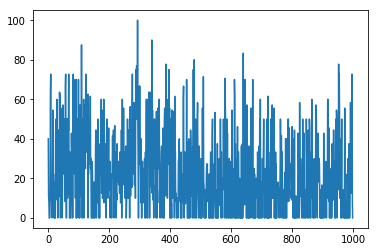

In [137]:
sspt = sorted(spt, key= lambda x: x[0])
y = [v[1] for v in sspt]
plt.plot(y)

In [ ]:
def relative_lr(label, base_lr):
  
  

In [143]:
y[444]

66.66666666592593

In [40]:
# RUN SITE
if 'x' in env.save_filename and mode != 'sanity_check':
  raise ValueError('save_filename contains x')


saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)
# fooling_weight_scheduler = FoolingWeightScheduler(learn)
# lr_anneal = LRAnneal(learn, 1e-4)
# file_ctrl = FileControl(learn, '/root/Derakhshani/adversarial/ctrl', learn.model)
# cyclical_sched = CyclicalLRScheduler(learn, 3e-2, 6e-4, 4)

callbacks = [saver_best, saver_every_epoch]
# callbacks.append(lr_anneal)
# callbacks.append(fooling_weight_scheduler)
# callbacks.append(file_ctrl)
# callbacks.append(cyclical_sched)
learn.fit(400, lr=1e-2, wd = 0., callbacks=callbacks)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/env.get_learner_models_dir(), env.get_models_path())
shutil.rmtree(env.data_path/env.get_learner_models_dir())

epoch,train_loss,valid_loss,validation,targeted_validation,div_metric,entropy,fool_loss,time
0,9.041856,9.073653,0.526000,0.000000,777.000000,9.600423,9.073654,04:42
1,7.967439,8.108307,0.547000,0.012000,500.500000,8.229180,8.108306,04:32
2,6.953693,7.048500,0.603000,0.042000,518.250000,8.528024,7.048499,04:27
3,5.848456,6.101434,0.607000,0.107000,457.250000,8.053362,6.101433,04:31
4,5.237603,5.322343,0.648000,0.180000,468.250000,8.143393,5.322344,04:31
5,4.933229,5.097449,0.636000,0.207000,475.250000,8.084688,5.097450,04:26
6,4.695633,4.868337,0.667000,0.232000,475.500000,8.058609,4.868337,04:24
7,4.506330,4.727351,0.670000,0.271000,469.250000,7.972008,4.727351,04:24
8,4.396331,4.593160,0.684000,0.286000,472.000000,7.974873,4.593160,04:25
9,4.189259,4.438077,0.677000,0.318000,471.250000,7.960370,4.438077,04:24


target probs tensor([[5.6856e-06],
        [1.9181e-04],
        [2.4252e-04],
        [9.9029e-05],
        [3.3708e-05],
        [8.0436e-04],
        [2.7772e-04],
        [2.2970e-05],
        [3.5408e-05],
        [1.3953e-03],
        [4.0851e-05],
        [8.5288e-04],
        [5.5088e-05],
        [5.9643e-04],
        [1.4670e-04],
        [1.0158e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.982696533203125: 
target probs tensor([[6.6124e-04],
        [3.7076e-04],
        [1.2855e-04],
        [1.2186e-04],
        [1.0856e-04],
        [5.0189e-04],
        [1.1911e-03],
        [2.2865e-05],
        [5.4431e-05],
        [5.5135e-06],
        [2.7301e-03],
        [6.8788e-05],
        [3.2972e-05],
        [2.9403e-05],
        [2.8128e-04],
        [8.7740e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.082886695861816: 
target probs tensor([[8.6046e-05],
        [1.8101e-03],
        [3.2466e-05],
        [1.0306e-05],
        [1.8002e-04],
     

target probs tensor([[9.6953e-02],
        [1.4153e-02],
        [1.8943e-04],
        [3.1195e-06],
        [1.0811e-04],
        [1.2395e-03],
        [1.3506e-01],
        [4.4689e-03],
        [2.6389e-04],
        [1.5691e-05],
        [1.0093e-04],
        [3.4234e-03],
        [2.2288e-03],
        [4.0787e-03],
        [1.2177e-01],
        [1.2841e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.6019287109375: 
target probs tensor([[1.0349e-05],
        [7.0680e-01],
        [1.0205e-03],
        [6.6276e-03],
        [7.7021e-04],
        [2.5208e-03],
        [2.1400e-04],
        [8.9124e-02],
        [1.2983e-05],
        [6.7472e-02],
        [2.1363e-04],
        [1.6230e-01],
        [7.8692e-01],
        [5.9596e-02],
        [4.2163e-02],
        [9.9164e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.175366401672363: 
Better model found at epoch 6 with validation value: 0.6669999957084656.
target probs tensor([[9.5383e-01],
        [7.9834e-02],


target probs tensor([[2.1121e-03],
        [3.6834e-01],
        [8.8952e-01],
        [5.3616e-05],
        [1.9429e-01],
        [9.9539e-01],
        [2.6956e-04],
        [1.1904e-01],
        [9.2791e-01],
        [1.9389e-02],
        [2.3823e-05],
        [8.1792e-03],
        [1.1272e-03],
        [1.0282e-02],
        [4.1869e-04],
        [4.6859e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.279394149780273: 
target probs tensor([[1.8842e-03],
        [5.8792e-01],
        [3.6426e-04],
        [4.8395e-03],
        [1.8307e-04],
        [3.7775e-03],
        [2.6874e-02],
        [3.8637e-01],
        [4.5881e-01],
        [2.3317e-01],
        [5.3797e-02],
        [5.7915e-01],
        [4.9109e-04],
        [9.8574e-05],
        [5.1371e-06],
        [9.6052e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.598292350769043: 
target probs tensor([[2.9243e-01],
        [9.8794e-01],
        [9.0855e-01],
        [1.7299e-01],
        [1.8950e-01],
     

target probs tensor([[5.3094e-05],
        [8.8648e-04],
        [7.3561e-01],
        [2.7547e-04],
        [2.0418e-04],
        [5.5559e-02],
        [2.0185e-02],
        [9.4625e-01],
        [1.9441e-02],
        [7.6897e-01],
        [9.9187e-01],
        [2.2961e-02],
        [1.2558e-01],
        [1.9334e-01],
        [9.4805e-02],
        [3.2754e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.9252400398254395: 
target probs tensor([[6.3852e-01],
        [3.1235e-01],
        [9.5488e-01],
        [1.0824e-04],
        [5.3435e-05],
        [8.2662e-01],
        [1.8306e-05],
        [3.3325e-05],
        [3.5248e-05],
        [6.9264e-01],
        [7.9765e-01],
        [8.7524e-01],
        [3.4730e-03],
        [1.0185e-03],
        [8.1283e-01],
        [2.1307e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.351395606994629: 
target probs tensor([[4.2736e-01],
        [2.9688e-02],
        [8.5263e-03],
        [1.8105e-01],
        [5.6477e-04],
    

target probs tensor([[4.8837e-02],
        [7.9016e-01],
        [9.6116e-01],
        [1.4525e-01],
        [9.2384e-02],
        [1.8665e-01],
        [2.6097e-01],
        [7.2068e-01],
        [1.4730e-01],
        [4.3645e-03],
        [3.2964e-04],
        [4.9273e-04],
        [4.6765e-02],
        [4.4810e-03],
        [7.7735e-03],
        [3.6939e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.1602249145507812: 
target probs tensor([[8.6363e-01],
        [1.0862e-02],
        [7.2978e-01],
        [1.5089e-01],
        [9.7461e-05],
        [1.7000e-05],
        [9.2583e-06],
        [1.1569e-05],
        [2.6630e-01],
        [9.0905e-01],
        [9.7817e-05],
        [2.1138e-01],
        [9.9224e-01],
        [9.9745e-01],
        [6.4352e-01],
        [2.9553e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.283195495605469: 
target probs tensor([[6.7184e-01],
        [4.0395e-02],
        [6.3885e-04],
        [1.7361e-01],
        [2.7659e-02],
    

target probs tensor([[5.0859e-03],
        [1.3834e-01],
        [1.2418e-02],
        [3.2280e-05],
        [2.8823e-01],
        [1.6836e-04],
        [2.2427e-05],
        [3.7645e-03],
        [2.3295e-01],
        [7.8913e-02],
        [5.3249e-03],
        [2.0257e-01],
        [9.4409e-01],
        [8.1816e-02],
        [1.3818e-01],
        [6.4523e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.4327545166015625: 
target probs tensor([[1.2874e-02],
        [1.5459e-02],
        [3.5099e-02],
        [9.0437e-05],
        [2.0161e-01],
        [8.3597e-01],
        [8.0963e-01],
        [6.4103e-01],
        [2.6063e-05],
        [9.9921e-01],
        [9.4090e-01],
        [9.1911e-01],
        [3.7700e-01],
        [9.7918e-01],
        [6.4249e-07],
        [4.5591e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.435309886932373: 
target probs tensor([[0.0403],
        [0.8451],
        [0.8528],
        [0.0012],
        [0.4821],
        [0.0048],
      

target probs tensor([[9.6527e-01],
        [7.9895e-01],
        [6.4671e-01],
        [9.8931e-01],
        [2.3619e-01],
        [7.1444e-01],
        [9.8014e-01],
        [7.1020e-01],
        [6.0482e-04],
        [6.8874e-01],
        [6.1687e-02],
        [3.0138e-02],
        [6.3069e-01],
        [1.7070e-02],
        [8.1321e-01],
        [4.5417e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.4029130935668945: 
target probs tensor([[2.1028e-01],
        [2.2963e-03],
        [3.4924e-01],
        [9.9757e-01],
        [1.3453e-03],
        [1.5218e-02],
        [5.6963e-01],
        [6.3479e-02],
        [1.1235e-04],
        [5.8021e-01],
        [4.1973e-05],
        [2.1623e-02],
        [1.3717e-02],
        [2.9500e-01],
        [1.6664e-01],
        [9.8180e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.3548355102539062: 
target probs tensor([[3.2008e-03],
        [6.8171e-04],
        [6.4680e-01],
        [1.4126e-01],
        [6.7044e-01],
   

target probs tensor([[9.4500e-01],
        [4.4365e-01],
        [2.7982e-01],
        [6.4573e-03],
        [2.8641e-04],
        [8.2109e-01],
        [5.8477e-04],
        [2.7995e-01],
        [2.6124e-02],
        [5.3593e-01],
        [1.4834e-02],
        [7.3444e-05],
        [3.1761e-02],
        [1.9023e-01],
        [3.0132e-04],
        [3.9193e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.5255987644195557: 
target probs tensor([[8.4066e-01],
        [9.7589e-01],
        [9.9081e-01],
        [2.1680e-03],
        [4.0697e-01],
        [6.3400e-02],
        [3.1456e-01],
        [1.4764e-04],
        [3.5853e-03],
        [7.3855e-02],
        [6.1043e-05],
        [1.2926e-04],
        [3.1101e-02],
        [3.4024e-05],
        [9.1381e-01],
        [1.2638e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.9242196083068848: 
target probs tensor([[5.1207e-01],
        [1.6571e-01],
        [1.0493e-02],
        [1.4465e-04],
        [1.7865e-01],
   

target probs tensor([[9.0627e-03],
        [3.6092e-04],
        [4.9797e-02],
        [2.4382e-03],
        [4.2509e-06],
        [2.5341e-06],
        [3.4840e-04],
        [6.1373e-01],
        [9.2842e-01],
        [7.6758e-05],
        [9.7857e-01],
        [3.2631e-02],
        [4.3681e-03],
        [4.0013e-05],
        [3.2402e-02],
        [3.6095e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.241596221923828: 
target probs tensor([[8.5899e-01],
        [7.5682e-05],
        [9.4563e-01],
        [3.8433e-01],
        [5.6382e-01],
        [9.8365e-01],
        [5.2020e-01],
        [4.8536e-05],
        [9.8135e-01],
        [3.9347e-02],
        [8.6097e-01],
        [9.1557e-01],
        [8.8149e-01],
        [9.7368e-01],
        [8.8662e-01],
        [1.4463e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 2.008330821990967: 
Better model found at epoch 50 with validation value: 0.7360000014305115.
target probs tensor([[8.7968e-01],
        [7.2251e-01

target probs tensor([[2.1115e-01],
        [5.5272e-02],
        [1.1643e-04],
        [7.0043e-01],
        [1.1714e-02],
        [1.6167e-06],
        [9.9630e-01],
        [2.0422e-03],
        [4.4528e-01],
        [9.8221e-01],
        [2.5179e-02],
        [7.6214e-05],
        [9.3704e-01],
        [3.5734e-02],
        [7.5331e-01],
        [4.4997e-01]], device='cuda:0'), loss: 3.5196077823638916: 
Better model found at epoch 56 with validation value: 0.7369999885559082.
target probs tensor([[2.8150e-03],
        [7.6457e-04],
        [6.9379e-07],
        [7.1369e-01],
        [5.3027e-01],
        [9.8120e-01],
        [1.2469e-02],
        [3.8619e-01],
        [4.7909e-02],
        [4.5760e-05],
        [7.7753e-01],
        [1.6254e-05],
        [1.6751e-04],
        [8.5228e-01],
        [9.8685e-01],
        [1.6068e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.429015159606934: 
target probs tensor([[0.2123],
        [0.2487],
        [0.9458],
        [0.9

target probs tensor([[1.8540e-03],
        [2.2594e-04],
        [8.0250e-02],
        [8.1893e-01],
        [3.9430e-01],
        [1.9719e-04],
        [1.1412e-02],
        [6.4513e-02],
        [9.2010e-01],
        [3.9517e-02],
        [1.2511e-02],
        [9.9677e-01],
        [1.5357e-04],
        [6.2973e-01],
        [5.1232e-04],
        [8.0952e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.9637198448181152: 
target probs tensor([[9.5385e-01],
        [9.0150e-03],
        [8.3953e-03],
        [1.3944e-01],
        [1.0316e-04],
        [9.5618e-01],
        [8.8683e-01],
        [8.8057e-01],
        [2.8615e-02],
        [9.5705e-01],
        [9.6749e-01],
        [1.2295e-02],
        [2.4522e-02],
        [2.3304e-03],
        [1.2341e-02],
        [8.5099e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 2.708315849304199: 
target probs tensor([[1.3790e-01],
        [5.6483e-05],
        [4.5919e-04],
        [2.0090e-01],
        [5.1607e-05],
    

target probs tensor([[3.6385e-01],
        [2.0199e-05],
        [5.0953e-04],
        [8.6667e-02],
        [3.8102e-01],
        [1.1401e-02],
        [2.0541e-06],
        [2.8549e-02],
        [9.3687e-01],
        [8.7549e-07],
        [5.9355e-01],
        [3.2251e-01],
        [9.6559e-01],
        [9.6602e-01],
        [1.6443e-02],
        [7.3773e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.293309211730957: 
target probs tensor([[2.0404e-02],
        [4.3236e-01],
        [7.9766e-04],
        [2.0596e-05],
        [9.2833e-01],
        [8.3704e-01],
        [2.8429e-02],
        [1.2102e-02],
        [9.9198e-01],
        [6.4312e-01],
        [1.0069e-04],
        [9.8888e-01],
        [1.1408e-02],
        [5.1371e-02],
        [9.7857e-01],
        [7.7987e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.0161399841308594: 
target probs tensor([[3.1151e-05],
        [8.9266e-01],
        [6.5986e-01],
        [1.2972e-06],
        [9.8250e-01],
    

target probs tensor([[9.8133e-01],
        [2.0625e-06],
        [5.4769e-03],
        [9.5303e-01],
        [6.0471e-01],
        [2.6341e-04],
        [3.8540e-01],
        [7.3675e-01],
        [9.9703e-01],
        [9.9425e-01],
        [5.0084e-02],
        [8.7617e-01],
        [2.0454e-04],
        [9.4967e-01],
        [4.4974e-04],
        [9.4688e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 2.9882688522338867: 
target probs tensor([[9.5442e-01],
        [7.9322e-01],
        [2.5672e-04],
        [9.2725e-01],
        [8.8584e-02],
        [8.2362e-03],
        [9.0408e-01],
        [1.2235e-03],
        [9.0907e-04],
        [5.9005e-04],
        [1.4464e-03],
        [2.4656e-01],
        [9.4513e-01],
        [5.4321e-03],
        [4.6201e-04],
        [3.7894e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.684414863586426: 
target probs tensor([[4.8371e-05],
        [5.8434e-03],
        [4.8793e-03],
        [1.3589e-01],
        [9.4408e-01],
    

target probs tensor([[8.4415e-01],
        [6.4052e-01],
        [1.9035e-04],
        [1.2648e-02],
        [1.3865e-01],
        [1.4037e-02],
        [3.5111e-01],
        [4.6901e-02],
        [1.9804e-06],
        [8.6200e-01],
        [3.3427e-03],
        [2.9376e-03],
        [9.2464e-01],
        [8.9921e-01],
        [2.3789e-04],
        [9.9318e-01]], device='cuda:0'), loss: 3.5779354572296143: 
target probs tensor([[2.8303e-03],
        [2.6518e-01],
        [9.0354e-01],
        [7.7573e-06],
        [3.9031e-03],
        [7.4888e-04],
        [9.6362e-05],
        [2.2191e-01],
        [2.8454e-03],
        [1.0729e-03],
        [2.2124e-04],
        [3.0005e-02],
        [9.4659e-01],
        [2.6534e-01],
        [2.1875e-01],
        [9.5288e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.670988082885742: 
target probs tensor([[9.8906e-01],
        [6.8556e-03],
        [5.3601e-02],
        [4.5756e-01],
        [7.7978e-01],
        [2.0044e-04],
        

target probs tensor([[8.1837e-01],
        [1.4760e-03],
        [9.9640e-01],
        [4.0361e-02],
        [6.8550e-01],
        [2.7827e-01],
        [8.9345e-01],
        [9.8923e-01],
        [7.2090e-01],
        [6.9953e-03],
        [9.4116e-01],
        [1.8266e-04],
        [8.6767e-01],
        [9.9491e-01],
        [1.8023e-02],
        [8.9892e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 2.1591105461120605: 
target probs tensor([[7.2659e-04],
        [9.3696e-01],
        [2.1025e-01],
        [7.8259e-03],
        [7.3092e-01],
        [3.6620e-03],
        [8.7291e-01],
        [8.7185e-01],
        [8.3833e-01],
        [5.7761e-03],
        [3.2255e-01],
        [9.9544e-01],
        [8.3731e-02],
        [9.9566e-01],
        [3.2628e-05],
        [9.0843e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 2.454726219177246: 
target probs tensor([[9.8329e-01],
        [9.8798e-01],
        [8.2676e-07],
        [1.8602e-03],
        [6.8822e-01],
    

target probs tensor([[1.5884e-03],
        [7.6597e-02],
        [2.4517e-04],
        [4.8977e-04],
        [2.2674e-04],
        [4.8691e-05],
        [7.5895e-06],
        [2.1238e-01],
        [5.2603e-01],
        [9.8833e-01],
        [5.1645e-02],
        [9.7113e-01],
        [3.4842e-02],
        [9.9282e-01],
        [9.9581e-01],
        [6.2906e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.293317794799805: 
target probs tensor([[7.6388e-05],
        [3.3538e-01],
        [8.6166e-01],
        [1.1158e-03],
        [6.8616e-03],
        [5.2213e-04],
        [5.4549e-04],
        [9.9961e-01],
        [4.7873e-03],
        [9.8673e-01],
        [9.7084e-01],
        [5.3989e-01],
        [9.7200e-01],
        [9.9235e-01],
        [7.4637e-03],
        [9.9244e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.0322086811065674: 
target probs tensor([[0.0047],
        [0.9340],
        [0.0022],
        [0.0017],
        [0.1535],
        [0.0521],
      

KeyboardInterrupt: 

In [33]:
shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/env.get_learner_models_dir(), env.get_models_path())
shutil.rmtree(env.data_path/env.get_learner_models_dir())

models_directory returned is:  models/529
models_directory returned is:  models/529


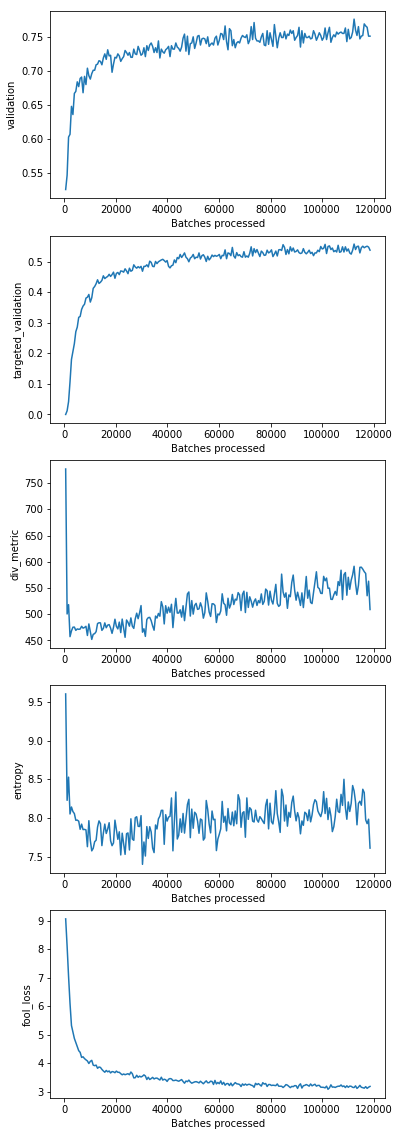

In [41]:
learn.recorder.plot_metrics()

In [29]:
from cleanup import cleanup_models_folder
cleanup_models_folder('/root/Derakhshani/adversarial/models')

In [34]:
total_histogram = fooled_histogram + unfooled_histogram
percent_total = [(i, 100. * u / (total_histogram[i] + 1e-10), total_histogram[i]) for i, u in enumerate(unfooled_histogram)]
sorted_percent_total = sorted(percent_total, key =lambda x: x[1], reverse = True)
print('\npercent_total: ')
print(list(filter(lambda x: x[1] > 0.0, sorted_percent_total)))


percent_total: 
[(7, 99.999999999, 10.0), (61, 99.999999999, 10.0), (90, 99.999999999, 10.0), (163, 99.999999999, 10.0), (274, 99.999999999, 10.0), (376, 99.999999999, 10.0), (398, 99.999999999, 10.0), (411, 99.999999999, 10.0), (464, 99.999999999, 10.0), (474, 99.999999999, 10.0), (483, 99.999999999, 10.0), (533, 99.999999999, 10.0), (566, 99.999999999, 10.0), (580, 99.999999999, 10.0), (625, 99.999999999, 10.0), (637, 99.999999999, 10.0), (661, 99.999999999, 10.0), (738, 99.999999999, 10.0), (783, 99.999999999, 10.0), (787, 99.999999999, 10.0), (791, 99.999999999, 10.0), (816, 99.999999999, 10.0), (937, 99.999999999, 10.0), (987, 99.999999999, 10.0), (292, 89.99999999955001, 20.0), (489, 89.99999999955001, 20.0), (37, 89.9999999991, 10.0), (45, 89.9999999991, 10.0), (66, 89.9999999991, 10.0), (96, 89.9999999991, 10.0), (102, 89.9999999991, 10.0), (242, 89.9999999991, 10.0), (291, 89.9999999991, 10.0), (331, 89.9999999991, 10.0), (498, 89.9999999991, 10.0), (506, 89.9999999991, 10.0)

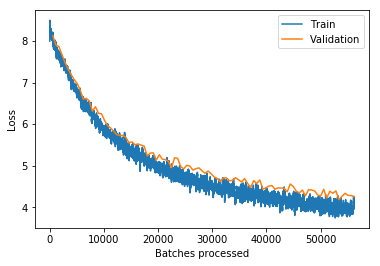

In [40]:
learn.recorder.plot_losses()

In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [52]:
# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

def targeted_diversity_average(learn, n_perturbations = 200, percentage = 95, average_over = 4):
  results = []
  for i in range(average_over):
    n, _ = targeted_diversity(learn, n_perturbations, percentage)
    print(f'done with the {i}th calculation: {n}')
    results.append(n)
  return np.mean(results)

def diversity_average(learn, n_perturbations = 10, percentage = 95, average_over = 4):
  results = []
  for i in range(average_over):
    n, _ = diversity(learn, n_perturbations, percentage, verbose = False)
    print(f'done with the {i}th calculation: {n}')
    results.append(n)
  return np.mean(results)

In [59]:
n, hist = diversity(learn, 10, 95)
n, hist

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
finished creating the prediction histogram


(566,
 [(794, 50.099998474121094),
  (599, 21.100000381469727),
  (668, 20.200000762939453),
  (904, 15.0),
  (973, 13.600000381469727),
  (490, 12.899999618530273),
  (39, 12.699999809265137),
  (770, 12.600000381469727),
  (741, 11.300000190734863),
  (828, 11.100000381469727),
  (109, 9.199999809265137),
  (556, 8.600000381469727),
  (489, 8.399999618530273),
  (955, 8.399999618530273),
  (887, 8.300000190734863),
  (669, 8.100000381469727),
  (84, 7.400000095367432),
  (855, 7.0),
  (538, 6.800000190734863),
  (108, 6.599999904632568),
  (124, 6.0),
  (397, 5.900000095367432),
  (48, 5.800000190734863),
  (61, 5.5),
  (777, 4.900000095367432),
  (721, 4.800000190734863),
  (401, 4.5),
  (971, 4.400000095367432),
  (893, 4.300000190734863),
  (857, 4.099999904632568),
  (591, 4.0),
  (711, 3.9000000953674316),
  (709, 3.799999952316284),
  (455, 3.700000047683716),
  (55, 3.5999999046325684),
  (414, 3.5),
  (906, 3.5),
  (151, 3.4000000953674316),
  (389, 3.4000000953674316),
  (40

In [207]:
results_1 = []
for n_pert in range(10, 110, 10):
  n = targeted_diversity_average(learn, n_pert, 95, 4)
  print(f'result for n_pert: {n_pert} is {n}')
  results_1.append(n)

at batch_no 0
done with the 0th calculation: 717
at batch_no 0
done with the 1th calculation: 718
at batch_no 0
done with the 2th calculation: 720
at batch_no 0
done with the 3th calculation: 718
result for n_pert: 10 is 718.25
at batch_no 0
done with the 0th calculation: 713
at batch_no 0
done with the 1th calculation: 724
at batch_no 0
done with the 2th calculation: 715
at batch_no 0
done with the 3th calculation: 719
result for n_pert: 20 is 717.75
at batch_no 0
done with the 0th calculation: 712
at batch_no 0
done with the 1th calculation: 722
at batch_no 0
done with the 2th calculation: 720
at batch_no 0
done with the 3th calculation: 717
result for n_pert: 30 is 717.75
at batch_no 0
done with the 0th calculation: 716
at batch_no 0
done with the 1th calculation: 717
at batch_no 0
done with the 2th calculation: 713
at batch_no 0
done with the 3th calculation: 714
result for n_pert: 40 is 715.0
at batch_no 0
done with the 0th calculation: 717
at batch_no 0
done with the 1th calculat

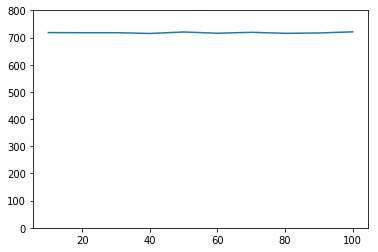

In [209]:
x = list(range(10, 110, 10))
plt.ylim(0, 800)
plt.plot(x, results_1)

In [204]:
results = []
for n_pert in range(10, 110, 10):
  n = diversity_average(learn, n_pert, 95, 3)
  print(f'result for n_pert: {n_pert} is {n}')
  results.append(n)

finished creating the prediction histogram
done with the 0th calculation: 548
finished creating the prediction histogram
done with the 1th calculation: 524
finished creating the prediction histogram
done with the 2th calculation: 519
result for n_pert: 10 is 530.3333333333334
finished creating the prediction histogram
done with the 0th calculation: 524
finished creating the prediction histogram
done with the 1th calculation: 546
finished creating the prediction histogram
done with the 2th calculation: 518
result for n_pert: 20 is 529.3333333333334
finished creating the prediction histogram
done with the 0th calculation: 561
finished creating the prediction histogram
done with the 1th calculation: 543
finished creating the prediction histogram
done with the 2th calculation: 523
result for n_pert: 30 is 542.3333333333334
finished creating the prediction histogram
done with the 0th calculation: 571
finished creating the prediction histogram
done with the 1th calculation: 548
finished crea

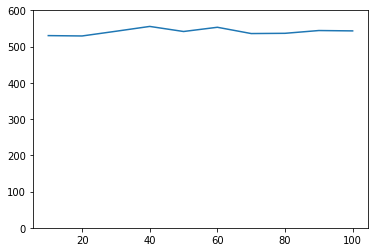

In [206]:
x = list(range(10, 110, 10))
plt.ylim(0, 600)
plt.plot(x, results)

In [219]:
#targeted:
targeted_div_metrics = results_1
div_metrics = results

#non-targeted:
n_targeted_div_metrics = [244.0, 247.0, 265.3333333333333, 246.66666666666666, 241.0, 231.33333333333334, 
                          247.66666666666666, 229.0, 222.33333333333334, 236.0]
n_div_metrics = [132, 118, 122, 135, 133, 129, 136, 132, 124, 143]

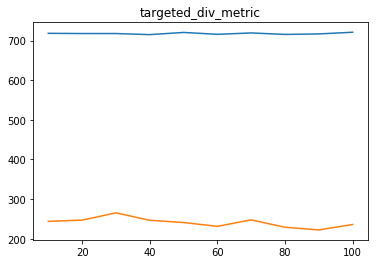

In [220]:
plt.plot(x, targeted_div_metrics)
plt.plot(x, n_targeted_div_metrics)
plt.title('targeted_div_metric')
plt.show()

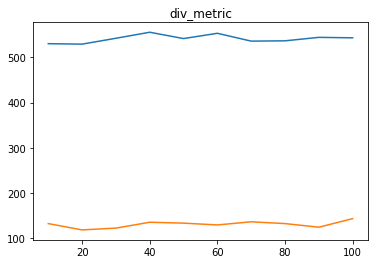

In [221]:
plt.plot(x, div_metrics)
plt.plot(x, n_div_metrics)
plt.title('div_metric')
plt.show()

In [30]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

In [29]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

In [28]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
finished creating the prediction histogram


(364,
 [(721, 143.20),
  (750, 49.40),
  (971, 48.40),
  (794, 47.10),
  (431, 35.10),
  (669, 35.10),
  (414, 30.60),
  (588, 28.40),
  (520, 24.90),
  (61, 24.20),
  (904, 18.30),
  (411, 14.30),
  (828, 13.50),
  (39, 11.70),
  (556, 11.40),
  (581, 9.20),
  (651, 8.30),
  (489, 7.80),
  (599, 6.60),
  (84, 5.50),
  (572, 4.80),
  (907, 4.70),
  (987, 4.40),
  (401, 4.30),
  (490, 4.30),
  (614, 4.30),
  (60, 4.00),
  (955, 3.50),
  (711, 3.30),
  (48, 3.20),
  (691, 3.10),
  (709, 3.00),
  (419, 2.90),
  (770, 2.90),
  (815, 2.90),
  (864, 2.80),
  (879, 2.80),
  (108, 2.70),
  (441, 2.70),
  (632, 2.70),
  (56, 2.50),
  (604, 2.50),
  (55, 2.40),
  (464, 2.30),
  (549, 2.30),
  (575, 2.20),
  (893, 2.20),
  (973, 2.20),
  (96, 2.10),
  (496, 2.10),
  (518, 2.10),
  (412, 2.00),
  (641, 2.00),
  (762, 2.00),
  (801, 2.00),
  (872, 2.00),
  (858, 1.90),
  (871, 1.90),
  (580, 1.80),
  (621, 1.80),
  (746, 1.80),
  (806, 1.80),
  (46, 1.70),
  (151, 1.70),
  (171, 1.70),
  (633, 1.70

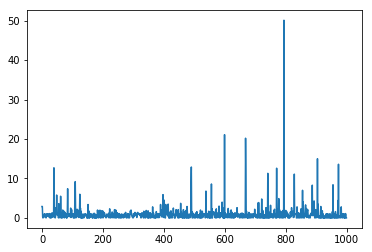

In [60]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [61]:
entropy(values)

tensor(8.6468)

In [97]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = targeted_diversity(learn, 10, 95)
n, hist 

at batch_no 0
at batch_no 100
at batch_no 200
at batch_no 300
at batch_no 400
at batch_no 500
at batch_no 600
at batch_no 700
at batch_no 800
at batch_no 900
at batch_no 1000
at batch_no 1100
at batch_no 1200
at batch_no 1300
at batch_no 1400
at batch_no 1500
at batch_no 1600
at batch_no 1700
at batch_no 1800
at batch_no 1900
at batch_no 2000
at batch_no 2100
at batch_no 2200
at batch_no 2300
at batch_no 2400
at batch_no 2500
at batch_no 2600
at batch_no 2700
at batch_no 2800
at batch_no 2900
at batch_no 3000
at batch_no 3100


(885,
 [(815, 234.00),
  (652, 177.00),
  (646, 163.00),
  (580, 160.00),
  (611, 156.00),
  (489, 145.00),
  (591, 144.00),
  (621, 141.00),
  (737, 139.00),
  (904, 130.00),
  (94, 129.00),
  (868, 127.00),
  (582, 125.00),
  (497, 123.00),
  (893, 120.00),
  (794, 118.00),
  (116, 115.00),
  (955, 115.00),
  (979, 114.00),
  (679, 112.00),
  (721, 109.00),
  (39, 108.00),
  (565, 108.00),
  (741, 106.00),
  (491, 105.00),
  (562, 103.00),
  (839, 102.00),
  (109, 101.00),
  (162, 101.00),
  (549, 99.00),
  (46, 97.00),
  (48, 96.00),
  (84, 95.00),
  (750, 95.00),
  (82, 94.00),
  (973, 94.00),
  (151, 93.00),
  (492, 93.00),
  (695, 93.00),
  (199, 91.00),
  (843, 89.00),
  (51, 88.00),
  (971, 88.00),
  (640, 87.00),
  (424, 86.00),
  (669, 86.00),
  (692, 86.00),
  (879, 86.00),
  (281, 85.00),
  (47, 84.00),
  (783, 84.00),
  (203, 83.00),
  (310, 83.00),
  (382, 83.00),
  (411, 83.00),
  (866, 83.00),
  (743, 82.00),
  (364, 81.00),
  (577, 81.00),
  (197, 80.00),
  (318, 80.00

In [98]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = targeted_diversity(learn, 10, 95)
n, hist 

at batch_no 0
at batch_no 100
at batch_no 200
at batch_no 300
at batch_no 400
at batch_no 500
at batch_no 600
at batch_no 700
at batch_no 800
at batch_no 900
at batch_no 1000
at batch_no 1100
at batch_no 1200
at batch_no 1300
at batch_no 1400
at batch_no 1500
at batch_no 1600
at batch_no 1700
at batch_no 1800
at batch_no 1900
at batch_no 2000
at batch_no 2100
at batch_no 2200
at batch_no 2300
at batch_no 2400
at batch_no 2500
at batch_no 2600
at batch_no 2700
at batch_no 2800
at batch_no 2900
at batch_no 3000
at batch_no 3100


(885,
 [(815, 239.00),
  (652, 181.00),
  (646, 168.00),
  (580, 163.00),
  (611, 155.00),
  (591, 148.00),
  (737, 143.00),
  (489, 142.00),
  (621, 139.00),
  (904, 134.00),
  (794, 130.00),
  (497, 127.00),
  (893, 127.00),
  (582, 125.00),
  (94, 123.00),
  (955, 120.00),
  (116, 115.00),
  (868, 115.00),
  (39, 112.00),
  (679, 112.00),
  (565, 110.00),
  (162, 109.00),
  (491, 108.00),
  (721, 108.00),
  (979, 108.00),
  (741, 105.00),
  (839, 105.00),
  (109, 104.00),
  (562, 104.00),
  (84, 103.00),
  (549, 102.00),
  (48, 99.00),
  (82, 99.00),
  (492, 99.00),
  (51, 98.00),
  (973, 96.00),
  (199, 95.00),
  (750, 95.00),
  (46, 93.00),
  (640, 92.00),
  (695, 92.00),
  (151, 88.00),
  (971, 88.00),
  (783, 87.00),
  (843, 87.00),
  (203, 86.00),
  (669, 86.00),
  (692, 86.00),
  (424, 84.00),
  (956, 84.00),
  (281, 83.00),
  (577, 83.00),
  (828, 82.00),
  (866, 82.00),
  (47, 81.00),
  (310, 81.00),
  (743, 81.00),
  (847, 81.00),
  (61, 80.00),
  (208, 80.00),
  (703, 80.0

In [99]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = targeted_diversity(learn, 10, 95)
n, hist 

at batch_no 0
at batch_no 100
at batch_no 200
at batch_no 300
at batch_no 400
at batch_no 500
at batch_no 600
at batch_no 700
at batch_no 800
at batch_no 900
at batch_no 1000
at batch_no 1100
at batch_no 1200
at batch_no 1300
at batch_no 1400
at batch_no 1500
at batch_no 1600
at batch_no 1700
at batch_no 1800
at batch_no 1900
at batch_no 2000
at batch_no 2100
at batch_no 2200
at batch_no 2300
at batch_no 2400
at batch_no 2500
at batch_no 2600
at batch_no 2700
at batch_no 2800
at batch_no 2900
at batch_no 3000
at batch_no 3100


(885,
 [(815, 227.00),
  (652, 183.00),
  (646, 172.00),
  (580, 155.00),
  (591, 149.00),
  (621, 148.00),
  (737, 148.00),
  (611, 147.00),
  (489, 136.00),
  (904, 129.00),
  (497, 125.00),
  (868, 125.00),
  (979, 124.00),
  (582, 122.00),
  (794, 122.00),
  (94, 118.00),
  (955, 118.00),
  (893, 117.00),
  (721, 116.00),
  (116, 114.00),
  (491, 108.00),
  (565, 108.00),
  (741, 107.00),
  (562, 106.00),
  (679, 106.00),
  (39, 105.00),
  (839, 104.00),
  (109, 102.00),
  (162, 101.00),
  (750, 100.00),
  (46, 98.00),
  (695, 98.00),
  (549, 97.00),
  (82, 95.00),
  (199, 95.00),
  (492, 95.00),
  (84, 94.00),
  (973, 94.00),
  (51, 93.00),
  (151, 91.00),
  (48, 90.00),
  (424, 89.00),
  (843, 89.00),
  (203, 87.00),
  (692, 87.00),
  (971, 87.00),
  (640, 86.00),
  (669, 86.00),
  (197, 84.00),
  (440, 84.00),
  (879, 84.00),
  (47, 83.00),
  (180, 83.00),
  (577, 83.00),
  (208, 81.00),
  (743, 81.00),
  (783, 81.00),
  (847, 81.00),
  (189, 80.00),
  (281, 80.00),
  (382, 80.0

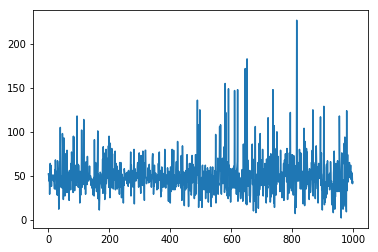

In [100]:
# on test
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [101]:
#on test
entropy(values)

tensor(9.8493)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)